# Neural Collaborative Filtering Recommenders

In [ ]:
!pip install -q pytorch-lightning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import pytorch_lightning as pl

np.random.seed(123)

## NCF with PyTorch Lightning on ML-25m

In this section, we will build a simple yet accurate model using movielens-25m dataset and pytorch lightning library. This will be a retrieval model where the objective is to maximize recall over precision.

In [ ]:
!wget -q --show-progress https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

ml-25m.zip.1        100%[===================>] 249.84M  45.7MB/s    in 5.9s    
Archive:  ml-25m.zip
replace ml-25m/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
ratings = pd.read_csv('ml-25m/ratings.csv', infer_datetime_format=True)
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Subset

In order to keep memory usage manageable, we will only use data from 20% of the users in this dataset. Let's randomly select 30% of the users and only use data from the selected users.

In [ ]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.2), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 5015129 rows of data from 32508 users


### Train/Test Split
**Chronological Leave-One-Out Split**

Along with the rating, there is also a timestamp column that shows the date and time the review was submitted. Using the timestamp column, we will implement our train-test split strategy using the leave-one-out methodology. For each user, the most recent review is used as the test set (i.e. leave one out), while the rest will be used as training data .

> Note: Doing a random split would not be fair, as we could potentially be using a user's recent reviews for training and earlier reviews for testing. This introduces data leakage with a look-ahead bias, and the performance of the trained model would not be generalizable to real-world performance.

In [ ]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

### Implicit Conversion

We will train a recommender system using implicit feedback. However, the MovieLens dataset that we're using is based on explicit feedback. To convert this dataset into an implicit feedback dataset, we'll simply binarize the ratings such that they are are '1' (i.e. positive class). The value of '1' represents that the user has interacted with the item.

> Note: Using implicit feedback reframes the problem that our recommender is trying to solve. Instead of trying to predict movie ratings (when using explicit feedback), we are trying to predict whether the user will interact (i.e. click/buy/watch) with each movie, with the aim of presenting to users the movies with the highest interaction likelihood.

> Tip: This setting is suitable at retrieval stage where the objective is to maximize recall by identifying items that user will at least interact with.

In [ ]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,userId,movieId,rating
9865540,64043,2019,1
17648975,114398,2671,1
19045758,123527,986,1
3125012,20593,86487,1
4540349,29803,4571,1


### Negative Sampling

We do have a problem now though. After binarizing our dataset, we see that every sample in the dataset now belongs to the positive class. However we also require negative samples to train our models, to indicate movies that the user has not interacted with. We assume that such movies are those that the user are not interested in - even though this is a sweeping assumption that may not be true, it usually works out rather well in practice.

The code below generates 4 negative samples for each row of data. In other words, the ratio of negative to positive samples is 4:1. This ratio is chosen arbitrarily but I found that it works rather well (feel free to find the best ratio yourself!)

In [ ]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

### PyTorch Dataset

Great! We now have the data in the format required by our model. Before we move on, let's define a PyTorch Dataset to facilitate training. The class below simply encapsulates the code we have written above into a PyTorch Dataset class.

In [ ]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

### Model

While there are many deep learning based architecture for recommendation systems, I find that the framework proposed by He et al. is the most straightforward and it is simple enough to be implemented in a tutorial such as this.

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=2)

We instantiate the NCF model using the class that we have defined above.

In [ ]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

### Model Training

> Note: One advantage of PyTorch Lightning over vanilla PyTorch is that you don't need to write your own boiler plate training code. Notice how the Trainer class allows us to train our model with just a few lines of code.

Let's train our NCF model for 5 epochs using the GPU. 

In [ ]:
trainer = pl.Trainer(max_epochs=5, gpus=1, reload_dataloaders_every_epoch=True,
                     progress_bar_refresh_rate=50, logger=False, checkpoint_callback=False)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 1.3 M 
1 | item_embedding | Embedding | 1.7 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.907    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze

> Note: We are using the argument reload_dataloaders_every_epoch=True. This creates a new randomly chosen set of negative samples for each epoch, which ensures that our model is not biased by the selection of negative samples.

### Evaluating our Recommender System

Now that our model is trained, we are ready to evaluate it using the test data. In traditional Machine Learning projects, we evaluate our models using metrics such as Accuracy (for classification problems) and RMSE (for regression problems). However, such metrics are too simplistic for evaluating recommender systems.

The key here is that we don't need the user to interact on every single item in the list of recommendations. Instead, we just need the user to interact with at least one item on the list - as long as the user does that, the recommendations have worked.

To simulate this, let's run the following evaluation protocol to generate a list of 10 recommended items for each user.
- For each user, randomly select 99 items that the user has not interacted with
- Combine these 99 items with the test item (the actual item that the user interacted with). We now have 100 items.
- Run the model on these 100 items, and rank them according to their predicted probabilities
- Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit.
- Repeat the process for all users. The Hit Ratio is then the average hits.

> Note: This evaluation protocol is known as Hit Ratio @ 10, and it is commonly used to evaluate recommender systems.

In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

We got a pretty good Hit Ratio @ 10 score! To put this into context, what this means is that 86% of the users were recommended the actual item (among a list of 10 items) that they eventually interacted with. Not bad!

## NMF with PyTorch on ML-1m

In [ ]:
import os
import time
import random
import argparse
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

In [ ]:
DATA_URL = "https://raw.githubusercontent.com/sparsh-ai/rec-data-public/master/ml-1m-dat/ratings.dat"
MAIN_PATH = '/content/'
DATA_PATH = MAIN_PATH + 'ratings.dat'
MODEL_PATH = MAIN_PATH + 'models/'
MODEL = 'ml-1m_Neu_MF'

!wget -q --show-progress https://raw.githubusercontent.com/sparsh-ai/rec-data-public/master/ml-1m-dat/ratings.dat

ratings.dat         100%[===================>]  23.45M   128MB/s    in 0.2s    


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

### Dataset

In [ ]:
class Rating_Datset(torch.utils.data.Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

- *_reindex*: process dataset to reindex userID and itemID, also set rating as binary feedback
- *_leave_one_out*: leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
- *negative_sampling*: randomly selects n negative examples for each positive one

In [ ]:
class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)
		random.seed(args.seed)
	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

### Metrics
Using Hit Rate and NDCG as our evaluation metrics

In [ ]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

### Models
- Generalized Matrix Factorization
- Multi Layer Perceptron
- Neural Matrix Factorization

In [ ]:
class Generalized_Matrix_Factorization(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(Generalized_Matrix_Factorization, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [ ]:
class Multi_Layer_Perceptron(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(Multi_Layer_Perceptron, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = args.factor_num
        self.factor_num_mlp =  int(args.layers[0]/2)
        self.layers = args.layers
        self.dropout = args.dropout

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(args.layers[:-1], args.layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        self.affine_output = nn.Linear(in_features=args.layers[-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)
        
        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
        nn.init.xavier_uniform_(self.affine_output.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

### Setting Arguments

Here is the brief description of important ones:
- Learning rate is 0.001
- Dropout rate is 0.2
- Running for 10 epochs
- HitRate@10 and NDCG@10
- 4 negative samples for each positive one

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=42, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=10,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+', 
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng", 
	type=int,
	default=4, 
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", 
	type=int,
	default=100, 
	help="Number of negative samples for test set")
parser.add_argument("--out", 
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, help='save model or not', metavar=None)

### Training

In [ ]:
# set device and parameters
args = parser.parse_args(args={})
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

# seed for Reproducibility
seed_everything(args.seed)

# load data
ml_1m = pd.read_csv(
	DATA_PATH, 
	sep="::", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_1m['user_id'].nunique()+1
num_items = ml_1m['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(args, ml_1m)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# set model and loss, optimizer
model = NeuMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs+1):
	model.train() # Enable dropout (if have).
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()
		writer.add_scalar('loss/Train_loss', loss.item(), epoch)

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)
	writer.add_scalar('Perfomance/HR@10', HR, epoch)
	writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

	elapsed_time = time.time() - start_time
	print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model, 
				'{}{}.pth'.format(MODEL_PATH, MODEL))

writer.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The time elapse of epoch 001 is: 00: 05: 41
HR: 0.626	NDCG: 0.359
The time elapse of epoch 002 is: 00: 05: 42
HR: 0.658	NDCG: 0.389
The time elapse of epoch 003 is: 00: 05: 47
HR: 0.664	NDCG: 0.396
The time elapse of epoch 004 is: 00: 05: 34
HR: 0.669	NDCG: 0.400
The time elapse of epoch 005 is: 00: 05: 44
HR: 0.671	NDCG: 0.401
The time elapse of epoch 006 is: 00: 05: 44
HR: 0.672	NDCG: 0.402
The time elapse of epoch 007 is: 00: 05: 39
HR: 0.668	NDCG: 0.396
The time elapse of epoch 008 is: 00: 05: 34
HR: 0.667	NDCG: 0.396
The time elapse of epoch 009 is: 00: 05: 41
HR: 0.668	NDCG: 0.397
The time elapse of epoch 010 is: 00: 05: 37
HR: 0.664	NDCG: 0.395


In [ ]:
print("Best epoch {:03d}: HR = {:.3f}, NDCG = {:.3f}".format(
									best_epoch, best_hr, best_ndcg))

Best epoch 006: HR = 0.672, NDCG = 0.402


## MF with PyTorch on ML-100k

Training Pytorch MLP model on movielens-100k dataset and visualizing factors by decomposing using PCA

In [ ]:
!pip install -U -q git+https://github.com/sparsh-ai/recochef.git

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

from recochef.datasets.movielens import MovieLens
from recochef.preprocessing.encode import label_encode
from recochef.utils.iterators import batch_generator
from recochef.models.embedding import EmbeddingNet

import math
import copy
import pickle
import numpy as np
import pandas as pd
from textwrap import wrap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Data loading and preprocessing

In [ ]:
data = MovieLens()

In [ ]:
ratings_df = data.load_interactions()
ratings_df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
movies_df = data.load_items()
movies_df.head()

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
ratings_df, umap = label_encode(ratings_df, 'USERID')
ratings_df, imap = label_encode(ratings_df, 'ITEMID')
ratings_df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,0,0,3.0,881250949
1,1,1,3.0,891717742
2,2,2,1.0,878887116
3,3,3,2.0,880606923
4,4,4,1.0,886397596


In [ ]:
X = ratings_df[['USERID','ITEMID']]
y = ratings_df[['RATING']]

In [ ]:
for _x_batch, _y_batch in batch_generator(X, y, bs=4):
    print(_x_batch)
    print(_y_batch)
    break

tensor([[873, 377],
        [808, 601],
        [ 90, 354],
        [409, 570]])
tensor([[4.],
        [3.],
        [4.],
        [2.]])


In [ ]:
_x_batch[:, 1]

tensor([377, 601, 354, 570])

### Embedding Net

The PyTorch is a framework that allows to build various computational graphs (not only neural networks) and run them on GPU. The conception of tensors, neural networks, and computational graphs is outside the scope of this article but briefly speaking, one could treat the library as a set of tools to create highly computationally efficient and flexible machine learning models. In our case, we want to create a neural network that could help us to infer the similarities between users and predict their ratings based on available data.

The picture above schematically shows the model we're going to build. At the very beginning, we put our embeddings matrices, or look-ups, which convert integer IDs into arrays of floating-point numbers. Next, we put a bunch of fully-connected layers with dropouts. Finally, we need to return a list of predicted ratings. For this purpose, we use a layer with sigmoid activation function and rescale it to the original range of values (in case of MovieLens dataset, it is usually from 1 to 5).

In [ ]:
netx = EmbeddingNet(
    n_users=50, n_items=20, 
    n_factors=10, hidden=[500], 
    embedding_dropout=0.05, dropouts=[0.5])
netx

EmbeddingNet(
  (u): Embedding(50, 10)
  (m): Embedding(20, 10)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=20, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

### Cyclical Learning Rate (CLR)

One of the `fastai` library features is the cyclical learning rate scheduler. We can implement something similar inheriting the `_LRScheduler` class from the `torch` library. Following the [original paper's](https://arxiv.org/abs/1506.01186) pseudocode, this [CLR Keras callback implementation](https://github.com/bckenstler/CLR), and making a couple of adjustments to support [cosine annealing](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR) with restarts, let's create our own CLR scheduler.

The implementation of this idea is quite simple. The [base PyTorch scheduler class](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html) has the `get_lr()` method that is invoked each time when we call the `step()` method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value. 

The next cell defines a `CyclicLR` class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [ ]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

Our scheduler is very similar to [LambdaLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.LambdaLR) one but expects a bit different callback signature. 

So now we only need to define appropriate scheduling functions. We're createing a couple of functions that accept scheduling parameters and return a _new function_ with the appropriate signature:

In [ ]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [ ]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

To understand how the created functions work, and to check the correctness of our implementation, let's create a couple of plots visualizing learning rates changes depending on the number of epoch:

In [ ]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

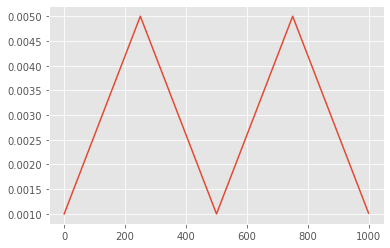

In [ ]:
plot_lr(triangular(250, 0.005))

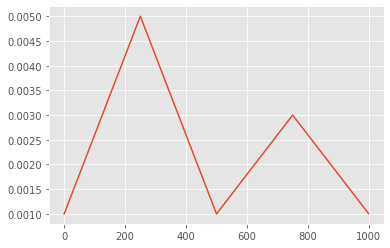

In [ ]:
plot_lr(triangular(250, 0.005, 'triangular2'))

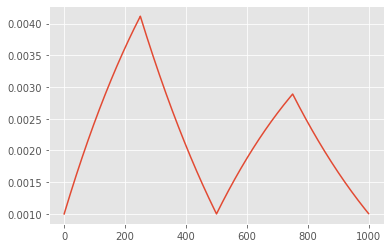

In [ ]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

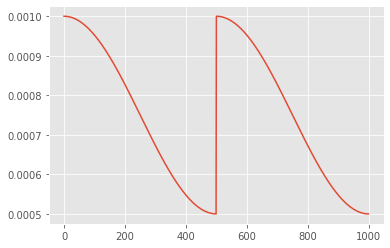

In [ ]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

### Training Loop

Now we're ready to start the training process. First of all, let's split the original dataset using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from the `scikit-learn` library. (Though you can use anything else instead, like, [get_cv_idxs](https://github.com/fastai/fastai/blob/921777feb46f215ed2b5f5dcfcf3e6edd299ea92/fastai/dataset.py#L6-L22) from `fastai`).

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [ ]:
minmax = ratings_df.RATING.astype(float).min(), ratings_df.RATING.astype(float).max()
minmax

(1.0, 5.0)

In [ ]:
n_users = ratings_df.USERID.nunique()
n_movies = ratings_df.ITEMID.nunique()
n_users, n_movies

(943, 1682)

In [ ]:
net = EmbeddingNet(
    n_users=n_users, n_items=n_movies, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

The next cell is preparing and running the training loop with cyclical learning rate, validation and early stopping. We use `Adam` optimizer with cosine-annealing learnign rate. The rate is decreased on each batch during `2` epochs, and then is reset to the original value.

Note that our loop has two phases. One of them is called `train`. During this phase, we update our network's weights and change the learning rate. The another one is called `val` and is used to check the model's performence. When the loss value decreases, we save model parameters to restore them later. If there is no improvements after `10` sequential training epochs, we exit from the loop.

In [ ]:
lr = 1e-3
wd = 1e-5
bs = 50
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batch_generator(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.9756 - val: 0.8986
loss improvement on epoch: 2
[002/100] train: 0.8512 - val: 0.8780
[003/100] train: 0.8775 - val: 0.8851
loss improvement on epoch: 4
[004/100] train: 0.8071 - val: 0.8705
loss improvement on epoch: 5
[005/100] train: 0.8338 - val: 0.8697
loss improvement on epoch: 6
[006/100] train: 0.7598 - val: 0.8624
[007/100] train: 0.7931 - val: 0.8698
[008/100] train: 0.7192 - val: 0.8733
[009/100] train: 0.7555 - val: 0.8743
[010/100] train: 0.6720 - val: 0.8844
[011/100] train: 0.7104 - val: 0.8882
[012/100] train: 0.6229 - val: 0.9149
[013/100] train: 0.6686 - val: 0.8936
[014/100] train: 0.5796 - val: 0.9359
[015/100] train: 0.6257 - val: 0.9201
[016/100] train: 0.5433 - val: 0.9525
early stopping after epoch 016


### Metrics

To visualize the training process and to check the correctness of the learning rate scheduling, let's create a couple of plots using collected stats:

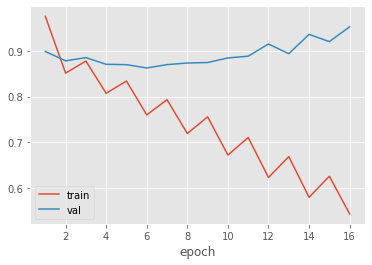

In [ ]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

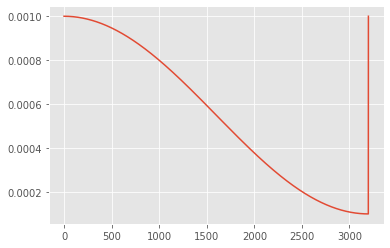

In [ ]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

As expected, the learning rate is updated in accordance with cosine annealing schedule.

The training process was terminated after _16 epochs_. Now we're going to restore the best weights saved during training, and apply the model to the validation subset of the data to see the final model's performance:

In [ ]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
# groud_truth, predictions = [], []

# with torch.no_grad():
#     for batch in batch_generator(*datasets['val'], shuffle=False, bs=bs):
#         x_batch, y_batch = [b.to(device) for b in batch]
#         outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
#         groud_truth.extend(y_batch.tolist())
#         predictions.extend(outputs.tolist())

# groud_truth = np.asarray(groud_truth).ravel()
# predictions = np.asarray(predictions).ravel()

In [ ]:
# final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
# print(f'Final RMSE: {final_loss:.4f}')

In [ ]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

### Embeddings Visualization

Finally, we can create a couple of visualizations to show how various movies are encoded in embeddings space. Again, we're repeting the approach shown in the original post and apply the [Principal Components Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimentionality of embeddings and show some of them with bar plots.

Loading previously saved weights:

In [ ]:
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

Creating the mappings between original users's and movies's IDs, and new contiguous values:

In [ ]:
maps.keys()

dict_keys(['ITEMID_TO_IDX', 'IDX_TO_ITEMID'])

In [ ]:
user_id_map = umap['USERID_TO_IDX']
movie_id_map = imap['ITEMID_TO_IDX']
embed_to_original = imap['IDX_TO_ITEMID']

popular_movies = ratings_df.groupby('ITEMID').ITEMID.count().sort_values(ascending=False).values[:1000]

Reducing the dimensionality of movie embeddings vectors:

In [ ]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

(5, 1000)

Finally, creating a joined data frame with projected embeddings and movies they represent:

In [ ]:
movies = movies_df[['ITEMID','TITLE']].dropna()
movies.shape

(1682, 2)

In [ ]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
components_df.head()

,fc0,fc1,fc2,fc3,fc4
0,-0.013240,-0.039103,0.061148,-0.050387,-0.020236
1,-0.020302,-0.040640,-0.005281,0.013627,0.022263
2,-0.046928,-0.006252,-0.027646,-0.012438,0.033915
3,0.068046,-0.001613,-0.042235,0.006097,-0.029498
4,-0.056585,-0.006064,-0.015407,-0.017673,-0.018524


In [ ]:
components_df.shape

(1000, 5)

In [ ]:
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('ITEMID')
components_df['ITEMID'] = movie_ids
components_df['TITLE'] = meta.reindex(movie_ids).TITLE.values
components_df.sample(4)

,fc0,fc1,fc2,fc3,fc4,ITEMID,TITLE
667,-0.011702,0.007813,0.044108,-0.036211,-0.002407,667,Audrey Rose (1977)
703,-0.007303,0.026804,0.073595,0.066034,0.041713,703,Widows' Peak (1994)
879,-0.025545,0.039012,-0.001066,-0.016779,0.006389,879,"Peacemaker, The (1997)"
197,-0.038626,0.002753,-0.045264,-0.033807,0.004753,197,"Graduate, The (1967)"


In [ ]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    labels = ['\n'.join(wrap(t, width=10)) for t in subset.TITLE]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

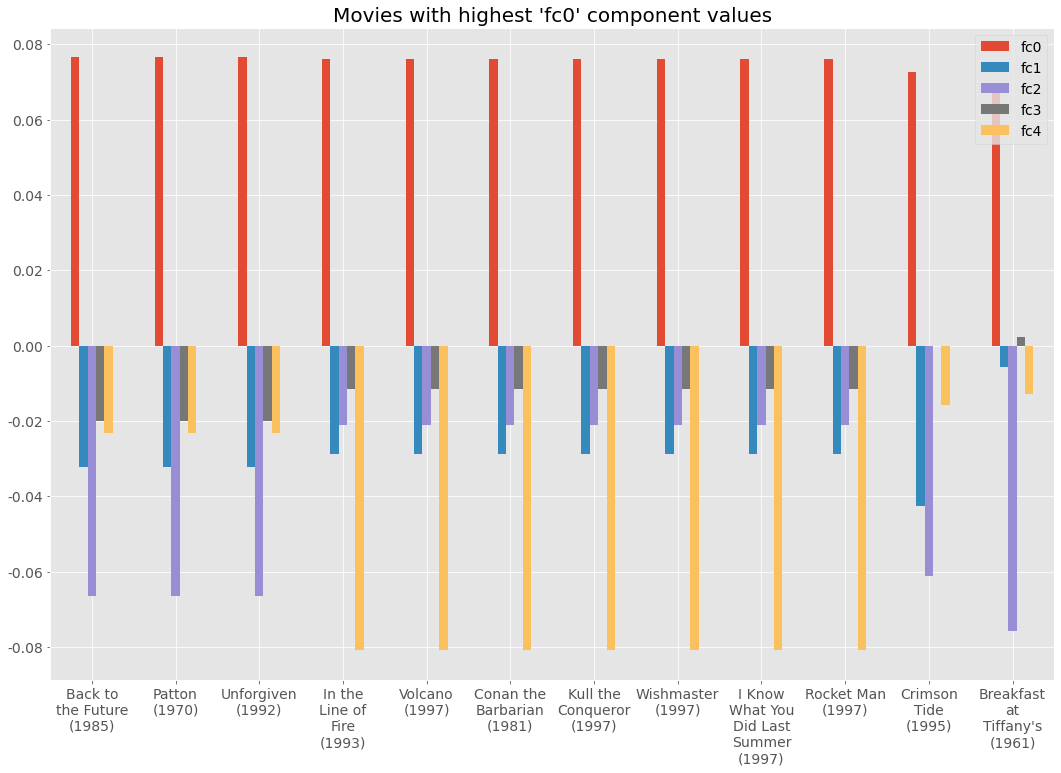

In [ ]:
plot_components(components_df, 'fc0', ascending=False)

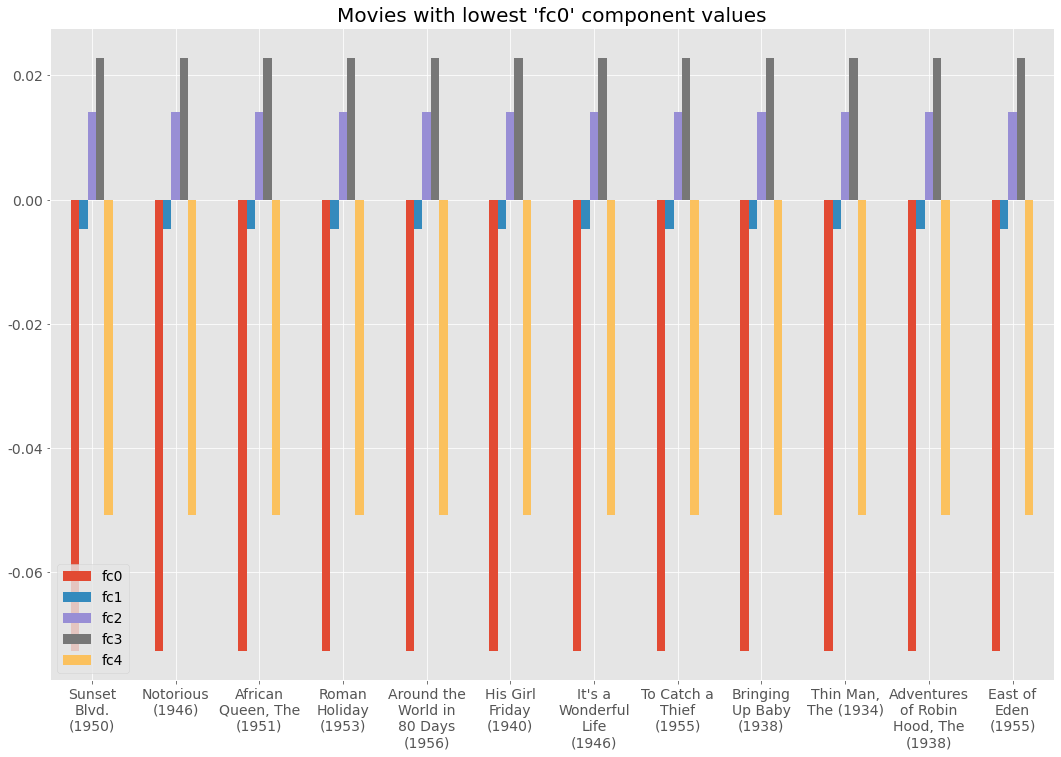

In [ ]:
plot_components(components_df, 'fc0', ascending=True)

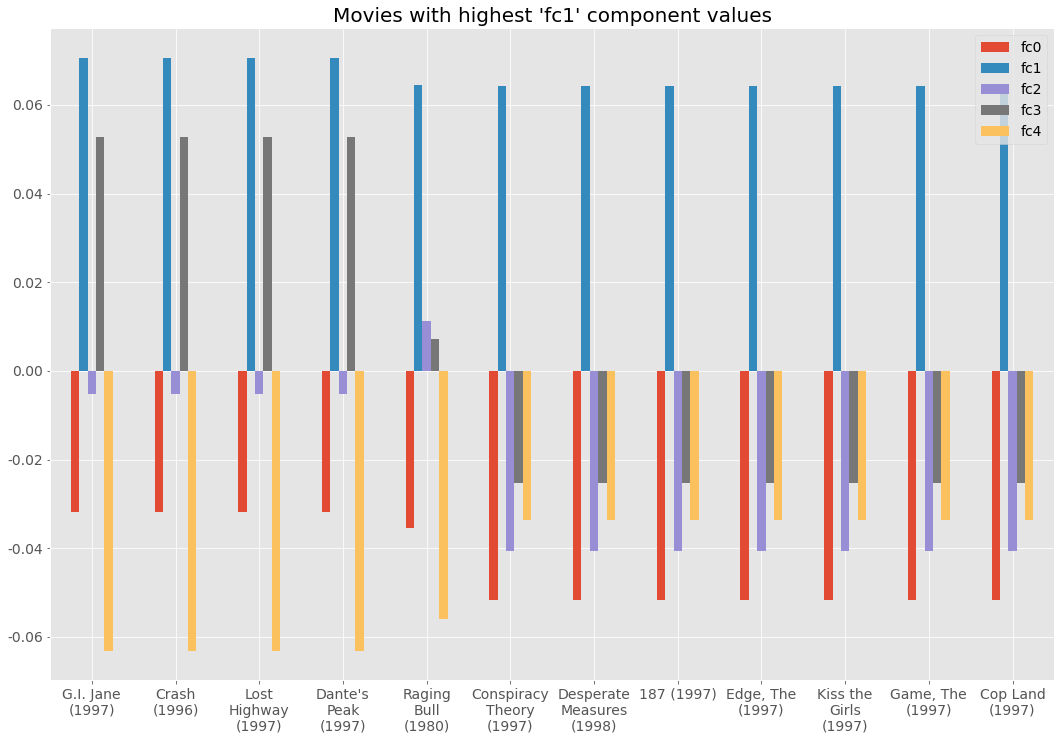

In [ ]:
plot_components(components_df, 'fc1', ascending=False)

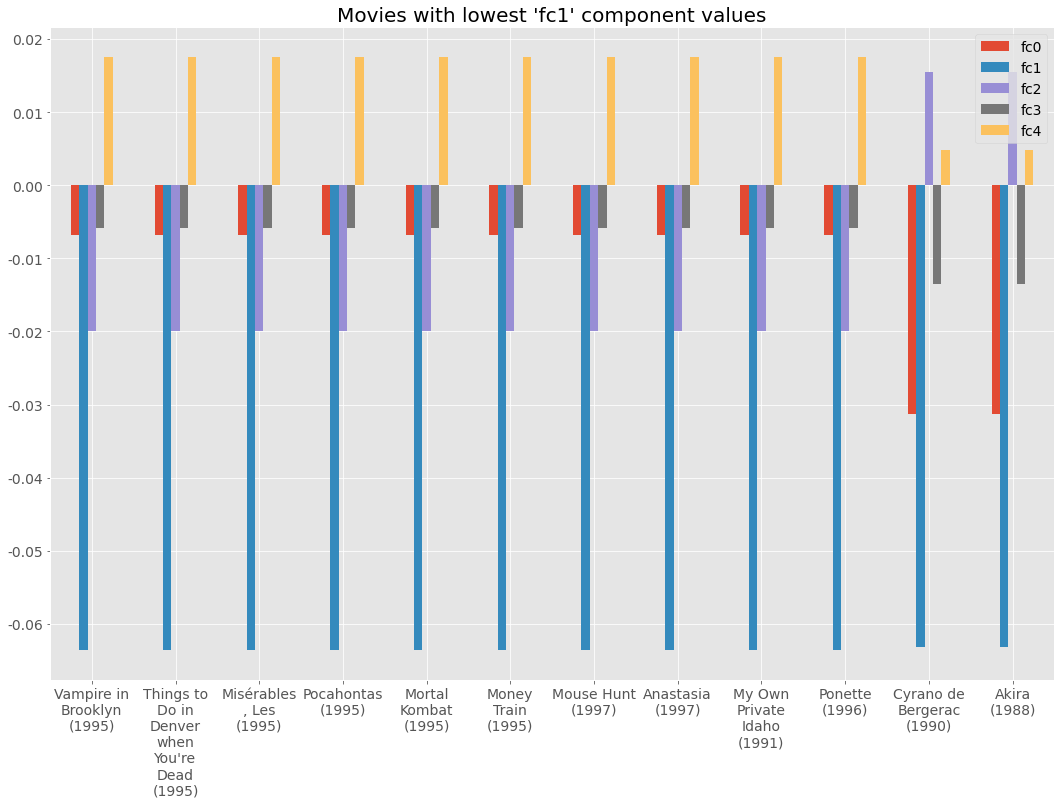

In [ ]:
plot_components(components_df, 'fc1', ascending=True)

Note that cosine annealing scheduler is a bit different from other schedules as soon as it starts with `base_lr` and gradually decreases it to the minimal value while triangle schedulers increase the original rate.

## MF with PyTorch on ML-100k

### Utils

In [ ]:
%%writefile utils.py

import os
import requests
import zipfile

import numpy as np
import pandas as pd
import scipy.sparse as sp

"""
Shamelessly stolen from
https://github.com/maciejkula/triplet_recommendations_keras
"""


def train_test_split(interactions, n=10):
    """
    Split an interactions matrix into training and test sets.
    Parameters
    ----------
    interactions : np.ndarray
    n : int (default=10)
        Number of items to select / row to place into test.

    Returns
    -------
    train : np.ndarray
    test : np.ndarray
    """
    test = np.zeros(interactions.shape)
    train = interactions.copy()
    for user in range(interactions.shape[0]):
        if interactions[user, :].nonzero()[0].shape[0] > n:
            test_interactions = np.random.choice(interactions[user, :].nonzero()[0],
                                                 size=n,
                                                 replace=False)
            train[user, test_interactions] = 0.
            test[user, test_interactions] = interactions[user, test_interactions]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test


def _get_data_path():
    """
    Get path to the movielens dataset file.
    """
    data_path = os.path.join(os.path.dirname(os.path.abspath(__file__)),
                        'data')
    if not os.path.exists(data_path):
        print('Making data path')
        os.mkdir(data_path)
    return data_path


def _download_movielens(dest_path):
    """
    Download the dataset.
    """

    url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    req = requests.get(url, stream=True)

    print('Downloading MovieLens data')

    with open(os.path.join(dest_path, 'ml-100k.zip'), 'wb') as fd:
        for chunk in req.iter_content(chunk_size=None):
            fd.write(chunk)

    with zipfile.ZipFile(os.path.join(dest_path, 'ml-100k.zip'), 'r') as z:
        z.extractall(dest_path)


def read_movielens_df():
    path = _get_data_path()
    zipfile = os.path.join(path, 'ml-100k.zip')
    if not os.path.isfile(zipfile):
        _download_movielens(path)
    fname = os.path.join(path, 'ml-100k', 'u.data')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(fname, sep='\t', names=names)
    return df


def get_movielens_interactions():
    df = read_movielens_df()

    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]

    interactions = np.zeros((n_users, n_items))
    for row in df.itertuples():
        interactions[row[1] - 1, row[2] - 1] = row[3]
    return interactions


def get_movielens_train_test_split(implicit=False):
    interactions = get_movielens_interactions()
    if implicit:
        interactions = (interactions >= 4).astype(np.float32)
    train, test = train_test_split(interactions)
    train = sp.coo_matrix(train)
    test = sp.coo_matrix(test)
    return train, test

Writing utils.py


### Metrics

In [ ]:
%%writefile metrics.py

import numpy as np
from sklearn.metrics import roc_auc_score
from torch import multiprocessing as mp
import torch


def get_row_indices(row, interactions):
    start = interactions.indptr[row]
    end = interactions.indptr[row + 1]
    return interactions.indices[start:end]


def auc(model, interactions, num_workers=1):
    aucs = []
    processes = []
    n_users = interactions.shape[0]
    mp_batch = int(np.ceil(n_users / num_workers))

    queue = mp.Queue()
    rows = np.arange(n_users)
    np.random.shuffle(rows)
    for rank in range(num_workers):
        start = rank * mp_batch
        end = np.min((start + mp_batch,  n_users))
        p = mp.Process(target=batch_auc,
                       args=(queue, rows[start:end], interactions, model))
        p.start()
        processes.append(p)

    while True:
        is_alive = False
        for p in processes:
            if p.is_alive():
                is_alive = True
                break
        if not is_alive and queue.empty():
            break

        while not queue.empty():
            aucs.append(queue.get())

    queue.close()
    for p in processes:
        p.join()
    return np.mean(aucs)


def batch_auc(queue, rows, interactions, model):
    n_items = interactions.shape[1]
    items = torch.arange(0, n_items).long()
    users_init = torch.ones(n_items).long()
    for row in rows:
        row = int(row)
        users = users_init.fill_(row)

        preds = model.predict(users, items)
        actuals = get_row_indices(row, interactions)

        if len(actuals) == 0:
            continue
        y_test = np.zeros(n_items)
        y_test[actuals] = 1
        queue.put(roc_auc_score(y_test, preds.data.numpy()))


def patk(model, interactions, num_workers=1, k=5):
    patks = []
    processes = []
    n_users = interactions.shape[0]
    mp_batch = int(np.ceil(n_users / num_workers))

    queue = mp.Queue()
    rows = np.arange(n_users)
    np.random.shuffle(rows)
    for rank in range(num_workers):
        start = rank * mp_batch
        end = np.min((start + mp_batch, n_users))
        p = mp.Process(target=batch_patk,
                       args=(queue, rows[start:end], interactions, model),
                       kwargs={'k': k})
        p.start()
        processes.append(p)

    while True:
        is_alive = False
        for p in processes:
            if p.is_alive():
                is_alive = True
                break
        if not is_alive and queue.empty():
            break

        while not queue.empty():
            patks.append(queue.get())

    queue.close()
    for p in processes:
        p.join()
    return np.mean(patks)


def batch_patk(queue, rows, interactions, model, k=5):
    n_items = interactions.shape[1]

    items = torch.arange(0, n_items).long()
    users_init = torch.ones(n_items).long()
    for row in rows:
        row = int(row)
        users = users_init.fill_(row)

        preds = model.predict(users, items)
        actuals = get_row_indices(row, interactions)

        if len(actuals) == 0:
            continue

        top_k = np.argpartition(-np.squeeze(preds.data.numpy()), k)
        top_k = set(top_k[:k])
        true_pids = set(actuals)
        if true_pids:
            queue.put(len(top_k & true_pids) / float(k))

Writing metrics.py


### Model

In [ ]:
%%writefile torchmf.py

import collections
import os

import numpy as np
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
import torch.multiprocessing as mp
import torch.utils.data as data
from tqdm import tqdm

import metrics


# Models
# Interactions Dataset => Singular Iter => Singular Loss
# Pairwise Datasets => Pairwise Iter => Pairwise Loss
# Pairwise Iters
# Loss Functions
# Optimizers
# Metric callbacks

# Serve up users, items (and items could be pos_items, neg_items)
# In this case, the iteration remains the same. Pass both items into a model
# which is a concat of the base model. it handles the pos and neg_items
# accordingly. define the loss after.


class Interactions(data.Dataset):
    """
    Hold data in the form of an interactions matrix.
    Typical use-case is like a ratings matrix:
    - Users are the rows
    - Items are the columns
    - Elements of the matrix are the ratings given by a user for an item.
    """

    def __init__(self, mat):
        self.mat = mat.astype(np.float32).tocoo()
        self.n_users = self.mat.shape[0]
        self.n_items = self.mat.shape[1]

    def __getitem__(self, index):
        row = self.mat.row[index]
        col = self.mat.col[index]
        val = self.mat.data[index]
        return (row, col), val

    def __len__(self):
        return self.mat.nnz


class PairwiseInteractions(data.Dataset):
    """
    Sample data from an interactions matrix in a pairwise fashion. The row is
    treated as the main dimension, and the columns are sampled pairwise.
    """

    def __init__(self, mat):
        self.mat = mat.astype(np.float32).tocoo()

        self.n_users = self.mat.shape[0]
        self.n_items = self.mat.shape[1]

        self.mat_csr = self.mat.tocsr()
        if not self.mat_csr.has_sorted_indices:
            self.mat_csr.sort_indices()

    def __getitem__(self, index):
        row = self.mat.row[index]
        found = False

        while not found:
            neg_col = np.random.randint(self.n_items)
            if self.not_rated(row, neg_col, self.mat_csr.indptr,
                              self.mat_csr.indices):
                found = True

        pos_col = self.mat.col[index]
        val = self.mat.data[index]

        return (row, (pos_col, neg_col)), val

    def __len__(self):
        return self.mat.nnz

    @staticmethod
    def not_rated(row, col, indptr, indices):
        # similar to use of bsearch in lightfm
        start = indptr[row]
        end = indptr[row + 1]
        searched = np.searchsorted(indices[start:end], col, 'right')
        if searched >= (end - start):
            # After the array
            return False
        return col != indices[searched]  # Not found

    def get_row_indices(self, row):
        start = self.mat_csr.indptr[row]
        end = self.mat_csr.indptr[row + 1]
        return self.mat_csr.indices[start:end]


class BaseModule(nn.Module):
    """
    Base module for explicit matrix factorization.
    """
    
    def __init__(self,
                 n_users,
                 n_items,
                 n_factors=40,
                 dropout_p=0,
                 sparse=False):
        """

        Parameters
        ----------
        n_users : int
            Number of users
        n_items : int
            Number of items
        n_factors : int
            Number of latent factors (or embeddings or whatever you want to
            call it).
        dropout_p : float
            p in nn.Dropout module. Probability of dropout.
        sparse : bool
            Whether or not to treat embeddings as sparse. NOTE: cannot use
            weight decay on the optimizer if sparse=True. Also, can only use
            Adagrad.
        """
        super(BaseModule, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.user_biases = nn.Embedding(n_users, 1, sparse=sparse)
        self.item_biases = nn.Embedding(n_items, 1, sparse=sparse)
        self.user_embeddings = nn.Embedding(n_users, n_factors, sparse=sparse)
        self.item_embeddings = nn.Embedding(n_items, n_factors, sparse=sparse)
        
        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(p=self.dropout_p)

        self.sparse = sparse
        
    def forward(self, users, items):
        """
        Forward pass through the model. For a single user and item, this
        looks like:

        user_bias + item_bias + user_embeddings.dot(item_embeddings)

        Parameters
        ----------
        users : np.ndarray
            Array of user indices
        items : np.ndarray
            Array of item indices

        Returns
        -------
        preds : np.ndarray
            Predicted ratings.

        """
        ues = self.user_embeddings(users)
        uis = self.item_embeddings(items)

        preds = self.user_biases(users)
        preds += self.item_biases(items)
        preds += (self.dropout(ues) * self.dropout(uis)).sum(dim=1, keepdim=True)

        return preds.squeeze()
    
    def __call__(self, *args):
        return self.forward(*args)

    def predict(self, users, items):
        return self.forward(users, items)


def bpr_loss(preds, vals):
    sig = nn.Sigmoid()
    return (1.0 - sig(preds)).pow(2).sum()


class BPRModule(nn.Module):
    
    def __init__(self,
                 n_users,
                 n_items,
                 n_factors=40,
                 dropout_p=0,
                 sparse=False,
                 model=BaseModule):
        super(BPRModule, self).__init__()

        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.dropout_p = dropout_p
        self.sparse = sparse
        self.pred_model = model(
            self.n_users,
            self.n_items,
            n_factors=n_factors,
            dropout_p=dropout_p,
            sparse=sparse
        )

    def forward(self, users, items):
        assert isinstance(items, tuple), \
            'Must pass in items as (pos_items, neg_items)'
        # Unpack
        (pos_items, neg_items) = items
        pos_preds = self.pred_model(users, pos_items)
        neg_preds = self.pred_model(users, neg_items)
        return pos_preds - neg_preds

    def predict(self, users, items):
        return self.pred_model(users, items)


class BasePipeline:
    """
    Class defining a training pipeline. Instantiates data loaders, model,
    and optimizer. Handles training for multiple epochs and keeping track of
    train and test loss.
    """

    def __init__(self,
                 train,
                 test=None,
                 model=BaseModule,
                 n_factors=40,
                 batch_size=32,
                 dropout_p=0.02,
                 sparse=False,
                 lr=0.01,
                 weight_decay=0.,
                 optimizer=torch.optim.Adam,
                 loss_function=nn.MSELoss(reduction='sum'),
                 n_epochs=10,
                 verbose=False,
                 random_seed=None,
                 interaction_class=Interactions,
                 hogwild=False,
                 num_workers=0,
                 eval_metrics=None,
                 k=5):
        self.train = train
        self.test = test

        if hogwild:
            num_loader_workers = 0
        else:
            num_loader_workers = num_workers
        self.train_loader = data.DataLoader(
            interaction_class(train), batch_size=batch_size, shuffle=True,
            num_workers=num_loader_workers)
        if self.test is not None:
            self.test_loader = data.DataLoader(
                interaction_class(test), batch_size=batch_size, shuffle=True,
                num_workers=num_loader_workers)
        self.num_workers = num_workers
        self.n_users = self.train.shape[0]
        self.n_items = self.train.shape[1]
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.dropout_p = dropout_p
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_function = loss_function
        self.n_epochs = n_epochs
        if sparse:
            assert weight_decay == 0.0
        self.model = model(self.n_users,
                           self.n_items,
                           n_factors=self.n_factors,
                           dropout_p=self.dropout_p,
                           sparse=sparse)
        self.optimizer = optimizer(self.model.parameters(),
                                   lr=self.lr,
                                   weight_decay=self.weight_decay)
        self.warm_start = False
        self.losses = collections.defaultdict(list)
        self.verbose = verbose
        self.hogwild = hogwild
        if random_seed is not None:
            if self.hogwild:
                random_seed += os.getpid()
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)

        if eval_metrics is None:
            eval_metrics = []
        self.eval_metrics = eval_metrics
        self.k = k

    def break_grads(self):
        for param in self.model.parameters():
            # Break gradient sharing
            if param.grad is not None:
                param.grad.data = param.grad.data.clone()

    def fit(self):
        for epoch in range(1, self.n_epochs + 1):

            if self.hogwild:
                self.model.share_memory()
                processes = []
                train_losses = []
                queue = mp.Queue()
                for rank in range(self.num_workers):
                    p = mp.Process(target=self._fit_epoch,
                                   kwargs={'epoch': epoch,
                                           'queue': queue})
                    p.start()
                    processes.append(p)
                for p in processes:
                    p.join()

                while True:
                    is_alive = False
                    for p in processes:
                        if p.is_alive():
                            is_alive = True
                            break
                    if not is_alive and queue.empty():
                        break

                    while not queue.empty():
                        train_losses.append(queue.get())
                queue.close()
                train_loss = np.mean(train_losses)
            else:
                train_loss = self._fit_epoch(epoch)

            self.losses['train'].append(train_loss)
            row = 'Epoch: {0:^3}  train: {1:^10.5f}'.format(epoch, self.losses['train'][-1])
            if self.test is not None:
                self.losses['test'].append(self._validation_loss())
                row += 'val: {0:^10.5f}'.format(self.losses['test'][-1])
                for metric in self.eval_metrics:
                    func = getattr(metrics, metric)
                    res = func(self.model, self.test_loader.dataset.mat_csr,
                               num_workers=self.num_workers)
                    self.losses['eval-{}'.format(metric)].append(res)
                    row += 'eval-{0}: {1:^10.5f}'.format(metric, res)
            self.losses['epoch'].append(epoch)
            if self.verbose:
                print(row)

    def _fit_epoch(self, epoch=1, queue=None):
        if self.hogwild:
            self.break_grads()

        self.model.train()
        total_loss = torch.Tensor([0])
        pbar = tqdm(enumerate(self.train_loader),
                    total=len(self.train_loader),
                    desc='({0:^3})'.format(epoch))
        for batch_idx, ((row, col), val) in pbar:
            self.optimizer.zero_grad()

            row = row.long()
            # TODO: turn this into a collate_fn like the data_loader
            if isinstance(col, list):
                col = tuple(c.long() for c in col)
            else:
                col = col.long()
            val = val.float()

            preds = self.model(row, col)
            loss = self.loss_function(preds, val)
            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()
            batch_loss = loss.item() / row.size()[0]
            pbar.set_postfix(train_loss=batch_loss)
        total_loss /= self.train.nnz
        if queue is not None:
            queue.put(total_loss[0])
        else:
            return total_loss[0]

    def _validation_loss(self):
        self.model.eval()
        total_loss = torch.Tensor([0])
        for batch_idx, ((row, col), val) in enumerate(self.test_loader):
            row = row.long()
            if isinstance(col, list):
                col = tuple(c.long() for c in col)
            else:
                col = col.long()
            val = val.float()

            preds = self.model(row, col)
            loss = self.loss_function(preds, val)
            total_loss += loss.item()

        total_loss /= self.test.nnz
        return total_loss[0]

Writing torchmf.py


### Trainer

In [ ]:
%%writefile run.py

import argparse
import pickle

import torch

from torchmf import (BaseModule, BPRModule, BasePipeline,
                     bpr_loss, PairwiseInteractions)
import utils


def explicit():
    train, test = utils.get_movielens_train_test_split()
    pipeline = BasePipeline(train, test=test, model=BaseModule,
                            n_factors=10, batch_size=1024, dropout_p=0.02,
                            lr=0.02, weight_decay=0.1,
                            optimizer=torch.optim.Adam, n_epochs=40,
                            verbose=True, random_seed=2017)
    pipeline.fit()


def implicit():
    train, test = utils.get_movielens_train_test_split(implicit=True)

    pipeline = BasePipeline(train, test=test, verbose=True,
                           batch_size=1024, num_workers=4,
                           n_factors=20, weight_decay=0,
                           dropout_p=0., lr=.2, sparse=True,
                           optimizer=torch.optim.SGD, n_epochs=40,
                           random_seed=2017, loss_function=bpr_loss,
                           model=BPRModule,
                           interaction_class=PairwiseInteractions,
                           eval_metrics=('auc', 'patk'))
    pipeline.fit()


def hogwild():
    train, test = utils.get_movielens_train_test_split(implicit=True)

    pipeline = BasePipeline(train, test=test, verbose=True,
                            batch_size=1024, num_workers=4,
                            n_factors=20, weight_decay=0,
                            dropout_p=0., lr=.2, sparse=True,
                            optimizer=torch.optim.SGD, n_epochs=40,
                            random_seed=2017, loss_function=bpr_loss,
                            model=BPRModule, hogwild=True,
                            interaction_class=PairwiseInteractions,
                            eval_metrics=('auc', 'patk'))
    pipeline.fit()


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='torchmf')
    parser.add_argument('--example',
                        help='explicit, implicit, or hogwild')
    args = parser.parse_args()
    if args.example == 'explicit':
        explicit()
    elif args.example == 'implicit':
        implicit()
    elif args.example == 'hogwild':
        hogwild()
    else:
        print('example must be explicit, implicit, or hogwild')

Writing run.py


### Explicit Model Training

In [ ]:
!python run.py --example explicit

Making data path
( 1 ): 100% 89/89 [00:01<00:00, 74.87it/s, train_loss=7.64] 
Epoch:  1   train:  14.61587 val:  8.83048  
( 2 ): 100% 89/89 [00:00<00:00, 112.92it/s, train_loss=2.5]
Epoch:  2   train:  4.20514  val:  4.05539  
( 3 ): 100% 89/89 [00:00<00:00, 112.48it/s, train_loss=1.57]
Epoch:  3   train:  1.86044  val:  2.45105  
( 4 ): 100% 89/89 [00:00<00:00, 113.76it/s, train_loss=1.15]
Epoch:  4   train:  1.20612  val:  1.82121  
( 5 ): 100% 89/89 [00:00<00:00, 110.97it/s, train_loss=0.966]
Epoch:  5   train:  0.98724  val:  1.51758  
( 6 ): 100% 89/89 [00:00<00:00, 112.02it/s, train_loss=0.89]
Epoch:  6   train:  0.89150  val:  1.35180  
( 7 ): 100% 89/89 [00:00<00:00, 112.91it/s, train_loss=0.906]
Epoch:  7   train:  0.83810  val:  1.25295  
( 8 ): 100% 89/89 [00:00<00:00, 108.44it/s, train_loss=0.873]
Epoch:  8   train:  0.80769  val:  1.18821  
( 9 ): 100% 89/89 [00:00<00:00, 113.67it/s, train_loss=0.83]
Epoch:  9   train:  0.78222  val:  1.15017  
(10 ): 100% 89/89 [00:00<00

### Implicit Model Training

In [ ]:
!python run.py --example implicit

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
( 1 ): 100% 46/46 [00:01<00:00, 28.55it/s, train_loss=0.382]
Epoch:  1   train:  0.41578  val:  0.39289  eval-auc:  0.55840  eval-patk:  0.00913  
( 2 ): 100% 46/46 [00:01<00:00, 28.86it/s, train_loss=0.323]
Epoch:  2   train:  0.34652  val:  0.34228  eval-auc:  0.61282  eval-patk:  0.01507  
( 3 ): 100% 46/46 [00:01<00:00, 30.01it/s, train_loss=0.273]
Epoch:  3   train:  0.27728  val:  0.31357  eval-auc:  0.65768  eval-patk:  0.02215  
( 4 ): 100% 46/46 [00:01<00:00, 29.36it/s, train_loss=0.226]
Epoch:  4   train:  0.23051  val:  0.29723

## Hybrid Model with PyTorch on ML-100k

Testing out the features of Collie Recs library on MovieLens-100K. Training Factorization and Hybrid models with Pytorch Lightning.

In [ ]:
!pip install -q collie_recs
!pip install -q git+https://github.com/sparsh-ai/recochef.git

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd

from collie_recs.interactions import Interactions
from collie_recs.interactions import ApproximateNegativeSamplingInteractionsDataLoader
from collie_recs.cross_validation import stratified_split
from collie_recs.metrics import auc, evaluate_in_batches, mapk, mrr
from collie_recs.model import CollieTrainer, MatrixFactorizationModel, HybridPretrainedModel
from collie_recs.movielens import get_recommendation_visualizations

import torch
from pytorch_lightning.utilities.seed import seed_everything

from recochef.datasets.movielens import MovieLens
from recochef.preprocessing.encode import label_encode as le

from IPython.display import HTML

In [ ]:
# this handy PyTorch Lightning function fixes random seeds across all the libraries used here
seed_everything(22)

Global seed set to 22


22

### Data Loading

In [ ]:
data_object = MovieLens()

In [ ]:
df = data_object.load_interactions()
df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


### Preprocessing

In [ ]:
# drop duplicate user-item pair records, keeping recent ratings only
df.drop_duplicates(subset=['USERID','ITEMID'], keep='last', inplace=True)

In [ ]:
# convert the explicit data to implicit by only keeping interactions with a rating ``>= 4``
df = df[df.RATING>=4].reset_index(drop=True)
df['RATING'] = 1

In [ ]:
# label encode
df, umap = le(df, col='USERID')
df, imap = le(df, col='ITEMID')

df = df.astype('int64')

In [ ]:
df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,0,0,1,884182806
1,1,1,1,891628467
2,2,2,1,879781125
3,3,3,1,876042340
4,4,4,1,879270459


In [ ]:
user_counts = df.groupby(by='USERID')['ITEMID'].count()
user_list = user_counts[user_counts>=3].index.tolist()
df = df[df.USERID.isin(user_list)]

df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,0,0,1,884182806
1,1,1,1,891628467
2,2,2,1,879781125
3,3,3,1,876042340
4,4,4,1,879270459


### Interactions
While we have chosen to represent the data as a ``pandas.DataFrame`` for easy viewing now, Collie uses a custom ``torch.utils.data.Dataset`` called ``Interactions``. This class stores a sparse representation of the data and offers some handy benefits, including: 

* The ability to index the data with a ``__getitem__`` method 
* The ability to sample many negative items (we will get to this later!) 
* Nice quality checks to ensure data is free of errors before model training 

Instantiating the object is simple! 

In [ ]:
interactions = Interactions(
    users=df['USERID'],
    items=df['ITEMID'],
    ratings=df['RATING'],
    allow_missing_ids=True,
)

interactions

Checking for and removing duplicate user, item ID pairs...
Checking ``num_negative_samples`` is valid...
Maximum number of items a user has interacted with: 378
Generating positive items set...


Interactions object with 55375 interactions between 942 users and 1447 items, returning 10 negative samples per interaction.

### Data Splits 
With an ``Interactions`` dataset, Collie supports two types of data splits. 

1. **Random split**: This code randomly assigns an interaction to a ``train``, ``validation``, or ``test`` dataset. While this is significantly faster to perform than a stratified split, it does not guarantee any balance, meaning a scenario where a user will have no interactions in the ``train`` dataset and all in the ``test`` dataset is possible. 
2. **Stratified split**: While this code runs slower than a random split, this guarantees that each user will be represented in the ``train``, ``validation``, and ``test`` dataset. This is by far the most fair way to train and evaluate a recommendation model. 

Since this is a small dataset and we have time, we will go ahead and use ``stratified_split``. If you're short on time, a ``random_split`` can easily be swapped in, since both functions share the same API! 

In [ ]:
train_interactions, val_interactions = stratified_split(interactions, test_p=0.1, seed=42)
train_interactions, val_interactions

Generating positive items set...
Generating positive items set...


(Interactions object with 49426 interactions between 942 users and 1447 items, returning 10 negative samples per interaction.,
 Interactions object with 5949 interactions between 942 users and 1447 items, returning 10 negative samples per interaction.)

### Model Architecture 
With our data ready-to-go, we can now start training a recommendation model. While Collie has several model architectures built-in, the simplest by far is the ``MatrixFactorizationModel``, which use ``torch.nn.Embedding`` layers and a dot-product operation to perform matrix factorization via collaborative filtering.

Digging through the code of [``collie_recs.model.MatrixFactorizationModel``](../collie_recs/model.py) shows the architecture is as simple as we might think. For simplicity, we will include relevant portions below so we know exactly what we are building: 

````python
def _setup_model(self, **kwargs) -> None:
    self.user_biases = ZeroEmbedding(num_embeddings=self.hparams.num_users,
                                     embedding_dim=1,
                                     sparse=self.hparams.sparse)
    self.item_biases = ZeroEmbedding(num_embeddings=self.hparams.num_items,
                                     embedding_dim=1,
                                     sparse=self.hparams.sparse)
    self.user_embeddings = ScaledEmbedding(num_embeddings=self.hparams.num_users,
                                           embedding_dim=self.hparams.embedding_dim,
                                           sparse=self.hparams.sparse)
    self.item_embeddings = ScaledEmbedding(num_embeddings=self.hparams.num_items,
                                           embedding_dim=self.hparams.embedding_dim,
                                           sparse=self.hparams.sparse)

        
def forward(self, users: torch.tensor, items: torch.tensor) -> torch.tensor:
    user_embeddings = self.user_embeddings(users)
    item_embeddings = self.item_embeddings(items)

    preds = (
        torch.mul(user_embeddings, item_embeddings).sum(axis=1)
        + self.user_biases(users).squeeze(1)
        + self.item_biases(items).squeeze(1)
    )

    if self.hparams.y_range is not None:
        preds = (
            torch.sigmoid(preds)
            * (self.hparams.y_range[1] - self.hparams.y_range[0])
            + self.hparams.y_range[0]
        )

    return preds
````

Let's go ahead and instantiate the model and start training! Note that even if you are running this model on a CPU instead of a GPU, this will still be relatively quick to fully train. 

Collie is built with PyTorch Lightning, so all the model classes and the ``CollieTrainer`` class accept all the training options available in PyTorch Lightning. Here, we're going to set the embedding dimension and learning rate differently, and go with the defaults for everything else

In [ ]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=10,
    lr=1e-2,
)

In [ ]:
trainer = CollieTrainer(model, max_epochs=10, deterministic=True)

trainer.fit(model)

```text
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 942   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)
Validation sanity check: 0%
0/2 [00:00<?, ?it/s]
Global seed set to 22
Epoch 9: 100%
55/55 [00:05<00:00, 10.37it/s, loss=1.74, v_num=0]
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.
```

### Evaluate the Model 
We have a model! Now, we need to figure out how well we did. Evaluating implicit recommendation models is a bit tricky, but Collie offers the following metrics that are built into the library. They use vectorized operations that can run on the GPU in a single pass for speed-ups. 

* [``Mean Average Precision at K (MAP@K)``](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) 
* [``Mean Reciprocal Rank``](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) 
* [``Area Under the Curve (AUC)``](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) 

We'll go ahead and evaluate all of these at once below. 

In [ ]:
model.eval()  # set model to inference mode
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')

```text
MAP@10 Score: 0.04792124467542778
MRR Score:    0.1670155641949101
AUC Score:    0.8854083361899018
```

### Inference

We can also look at particular users to get a sense of what the recs look like. 

In [ ]:
# select a random user ID to look at recommendations for
user_id = np.random.randint(10, train_interactions.num_users)

display(
    HTML(
        get_recommendation_visualizations(
            model=model,
            user_id=user_id,
            filter_films=True,
            shuffle=True,
            detailed=True,
        )
    )
)

,Willy Wonka and the Chocolate Factory (1971),Mighty Aphrodite (1995),Conspiracy Theory (1997),Sense and Sensibility (1995),Liar Liar (1997),In & Out (1997),Return of the Jedi (1983),Ransom (1996),Emma (1996),Toy Story (1995)
Some loved films:,,,,,,,,,,
,"Princess Bride, The (1987)","Graduate, The (1967)",Cold Comfort Farm (1995),"Apartment, The (1960)",Jerry Maguire (1996),Sleeper (1973),Independence Day (ID4) (1996),Desperado (1995),Three Colors: Red (1994),"Lawnmower Man, The (1992)"
Recommended films:,,,,,,,,,,


### Save and Load a Standard Model 

In [ ]:
# we can save the model with...
os.makedirs('models', exist_ok=True)
model.save_model('models/matrix_factorization_model.pth')

In [ ]:
# ... and if we wanted to load that model back in, we can do that easily...
model_loaded_in = MatrixFactorizationModel(load_model_path='models/matrix_factorization_model.pth')

model_loaded_in

MatrixFactorizationModel(
  (user_biases): ZeroEmbedding(942, 1)
  (item_biases): ZeroEmbedding(1447, 1)
  (user_embeddings): ScaledEmbedding(942, 10)
  (item_embeddings): ScaledEmbedding(1447, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

Now that we've built our first model and gotten some baseline metrics, we now will be looking at some more advanced features in Collie's ``MatrixFactorizationModel``. 

### Faster Data Loading Through Approximate Negative Sampling 

With sufficiently large enough data, verifying that each negative sample is one a user has *not* interacted with becomes expensive. With many items, this can soon become a bottleneck in the training process. 

Yet, when we have many items, the chances a user has interacted with most is increasingly rare. Say we have ``1,000,000`` items and we want to sample ``10`` negative items for a user that has positively interacted with ``200`` items. The chance that we accidentally select a positive item in a random sample of ``10`` items is just ``0.2%``. At that point, it might be worth it to forgo the expensive check to assert our negative sample is true, and instead just randomly sample negative items with the hope that most of the time, they will happen to be negative. 

This is the theory behind the ``ApproximateNegativeSamplingInteractionsDataLoader``, an alternate DataLoader built into Collie. Let's train a model with this below, noting how similar this procedure looks to that in the previous tutorial. 

In [ ]:
train_loader = ApproximateNegativeSamplingInteractionsDataLoader(train_interactions, batch_size=1024, shuffle=True)
val_loader = ApproximateNegativeSamplingInteractionsDataLoader(val_interactions, batch_size=1024, shuffle=False)

In [ ]:
model = MatrixFactorizationModel(
    train=train_loader,
    val=val_loader,
    embedding_dim=10,
    lr=1e-2,
)

In [ ]:
trainer = CollieTrainer(model, max_epochs=10, deterministic=True)

trainer.fit(model)
model.eval()

```text
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)
Detected GPU. Setting ``gpus`` to 1.
Global seed set to 22

MatrixFactorizationModel(
  (user_biases): ZeroEmbedding(941, 1)
  (item_biases): ZeroEmbedding(1447, 1)
  (user_embeddings): ScaledEmbedding(941, 10)
  (item_embeddings): ScaledEmbedding(1447, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)
```

In [ ]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.027979833367276323
MRR Score:    0.1703751336709069
AUC Score:    0.8517987786322347


We're seeing a small hit on performance and only a marginal improvement in training time compared to the standard ``MatrixFactorizationModel`` model because MovieLens 100K has so few items. ``ApproximateNegativeSamplingInteractionsDataLoader`` is especially recommended for when we have more items in our data and training times need to be optimized. 

For more details on this and other DataLoaders in Collie (including those for out-of-memory datasets), check out the [docs](https://collie.readthedocs.io/en/latest/index.html)! 

### Multiple Optimizers 

Training recommendation models at ShopRunner, we have encountered something we call "the curse of popularity." 

This is best thought of in the viewpoint of a model optimizer - say we have a user, a positive item, and several negative items that we hope have recommendation scores that score lower than the positive item. As an optimizer, you can either optimize every single embedding dimension (hundreds of parameters) to achieve this, or instead choose to score a quick win by optimizing the bias terms for the items (just add a positive constant to the positive item and a negative constant to each negative item). 

While we clearly want to have varied embedding layers that reflect each user and item's taste profiles, some models learn to settle for popularity as a recommendation score proxy by over-optimizing the bias terms, essentially just returning the same set of recommendations for every user. Worst of all, since popular items are... well, popular, **the loss of this model will actually be decent, solidifying the model getting stuck in a local loss minima**. 

To counteract this, Collie supports multiple optimizers in a ``MatrixFactorizationModel``. With this, we can have a faster optimizer work to optimize the embedding layers for users and items, and a slower optimizer work to optimize the bias terms. With this, we impel the model to do the work actually coming up with varied, personalized recommendations for users while still taking into account the necessity of the bias (popularity) terms on recommendations. 

At ShopRunner, we have seen significantly better metrics and results from this type of model. With Collie, this is simple to do, as shown below. 

In [ ]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=10,
    lr=1e-2,
    bias_lr=1e-1,
    optimizer='adam',
    bias_optimizer='sgd',
)

In [ ]:
trainer = CollieTrainer(model, max_epochs=10, deterministic=True)

trainer.fit(model)
model.eval()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-02.


MatrixFactorizationModel(
  (user_biases): ZeroEmbedding(941, 1)
  (item_biases): ZeroEmbedding(1447, 1)
  (user_embeddings): ScaledEmbedding(941, 10)
  (item_embeddings): ScaledEmbedding(1447, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.03243186201880122
MRR Score:    0.19819369246580287
AUC Score:    0.8617710409716284


Again, we're not seeing as much performance increase here compared to the standard model because MovieLens 100K has so few items. For a more dramatic difference, try training this model on a larger dataset, such as MovieLens 10M, adjusting the architecture-specific hyperparameters, or train longer. 

### Item-Item Similarity 

While we've trained every model thus far to work for member-item recommendations (given a *member*, recommend *items* - think of this best as "Personalized recommendations for you"), we also have access to item-item recommendations for free (given a seed *item*, recommend similar *items* - think of this more like "People who interacted with this item also interacted with..."). 

With Collie, accessing this is simple! 

In [ ]:
df_item = data_object.load_items()
df_item.head()

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_item = le(df_item, col='ITEMID', maps=imap)
df_item.head()

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
0,9.0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,160.0,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,579.0,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,25.0,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,436.0,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_item.loc[df_item['TITLE'] == 'GoldenEye (1995)']

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
1,160.0,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# let's start by finding movies similar to GoldenEye (1995)
item_similarities = model.item_item_similarity(item_id=160)

item_similarities

160    1.000000
123    0.842003
948    0.828162
398    0.827030
197    0.826931
         ...   
26    -0.654127
88    -0.680429
165   -0.697536
499   -0.729313
312   -0.780792
Length: 1447, dtype: float64

In [ ]:
df_item.iloc[item_similarities.index][:5]

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
162,182.0,"Return of the Pink Panther, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
125,229.0,"Spitfire Grill, The (1996)",06-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Spitfire%20Gr...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
975,933.0,Solo (1996),23-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Solo%20(1996),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
401,175.0,Ghost (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Ghost%20(1990),0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
199,72.0,"Shining, The (1980)",01-Jan-1980,NaN,"http://us.imdb.com/M/title-exact?Shining,%20Th...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Unfortunately, not seen these movies. Can't say if these are relevant.

``item_item_similarity`` method is available in all Collie models, not just ``MatrixFactorizationModel``! 

Next, we will incorporate item metadata into recommendations for even better results.

### Partial Credit Loss
Most of the time, we don't *only* have user-item interactions, but also side-data about our items that we are recommending. These next two notebooks will focus on incorporating this into the model training process. 

In this notebook, we're going to add a new component to our loss function - "partial credit". Specifically, we're going to use the genre information to give our model "partial credit" for predicting that a user would like a movie that they haven't interacted with, but is in the same genre as one that they liked. The goal is to help our model learn faster from these similarities. 

### Read in Data

To do the partial credit calculation, we need this data in a slightly different form. Instead of the one-hot-encoded version above, we're going to make a ``1 x n_items`` tensor with a number representing the first genre associated with the film, for simplicity. Note that with Collie, we could instead make a metadata tensor for each genre

In [ ]:
df_item.columns[5:]

Index(['UNKNOWN', 'ACTION', 'ADVENTURE', 'ANIMATION', 'CHILDREN', 'COMEDY',
       'CRIME', 'DOCUMENTARY', 'DRAMA', 'FANTASY', 'FILMNOIR', 'HORROR',
       'MUSICAL', 'MYSTERY', 'ROMANCE', 'SCIFI', 'THRILLER', 'WAR', 'WESTERN'],
      dtype='object')

In [ ]:
metadata_df = df_item[df_item.columns[5:]]

In [ ]:
genres = (
    torch.tensor(metadata_df.values)
    .topk(1)
    .indices
    .view(-1)
)

genres

tensor([ 5,  1, 16,  ..., 14,  5,  8])

### Train a model with our new loss

now, we will pass in ``metadata_for_loss`` and ``metadata_for_loss_weights`` into the model ``metadata_for_loss`` should have a tensor containing the integer representations for metadata we created above for every item ID in our dataset ``metadata_for_loss_weights`` should have the weights for each of the keys in ``metadata_for_loss``

In [ ]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=10,
    lr=1e-2,
    metadata_for_loss={'genre': genres},
    metadata_for_loss_weights={'genre': 0.4},
)

In [ ]:
trainer = CollieTrainer(model=model, max_epochs=10, deterministic=True)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.


### Evaluate the Model 

Again, we'll evaluate the model and look at some particular users' recommendations to get a sense of what these recommendations look like using a partial credit loss function during model training. 

In [ ]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.02882727154889818
MRR Score:    0.1829242957435939
AUC Score:    0.8585049499223719


Broken record alert: we're not seeing as much performance increase here compared to the standard model because MovieLens 100K has so few items. For a more dramatic difference, try training this model on a larger dataset, such as MovieLens 10M, adjusting the architecture-specific hyperparameters, or train longer. 

### Inference

In [ ]:
user_id = np.random.randint(10, train_interactions.num_users)

display(
    HTML(
        get_recommendation_visualizations(
            model=model,
            user_id=user_id,
            filter_films=True,
            shuffle=True,
            detailed=True,
        )
    )
)

,Willy Wonka and the Chocolate Factory (1971),Mighty Aphrodite (1995),Conspiracy Theory (1997),Sense and Sensibility (1995),Liar Liar (1997),In & Out (1997),Return of the Jedi (1983),Ransom (1996),Emma (1996),Toy Story (1995)
Some loved films:,,,,,,,,,,
,Cold Comfort Farm (1995),"Apartment, The (1960)",Blown Away (1994),Star Wars (1977),Star Trek: First Contact (1996),"Sex, Lies, and Videotape (1989)","Big Squeeze, The (1996)","Client, The (1994)",Jerry Maguire (1996),"Ghost and the Darkness, The (1996)"
Recommended films:,,,,,,,,,,


Partial credit loss is useful when we want an easy way to boost performance of any implicit model architecture, hybrid or not. When tuned properly, partial credit loss more fairly penalizes the model for more egregious mistakes and relaxes the loss applied when items are more similar. 

Of course, the loss function isn't the only place we can incorporate this metadata - we can also directly use this in the model (and even use a hybrid model combined with partial credit loss). Next, we will train a hybrid Collie model! 

### Train a ``MatrixFactorizationModel`` 

The first step towards training a Collie Hybrid model is to train a regular ``MatrixFactorizationModel`` to generate rich user and item embeddings. We'll use these embeddings in a ``HybridPretrainedModel`` a bit later. 

In [ ]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=30,
    lr=1e-2,
)

In [ ]:
trainer = CollieTrainer(model=model, max_epochs=10, deterministic=True)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 28.2 K
3 | item_embeddings | ScaledEmbedding | 43.4 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
74.0 K    Trainable params
0         Non-trainable params
74.0 K    Total params
0.296     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


In [ ]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'Standard MAP@10 Score: {mapk_score}')
print(f'Standard MRR Score:    {mrr_score}')
print(f'Standard AUC Score:    {auc_score}')


Standard MAP@10 Score: 0.024415062120220127
Standard MRR Score:    0.1551878337645617
Standard AUC Score:    0.8575152364604943


### Train a ``HybridPretrainedModel`` 

With our trained ``model`` above, we can now use these embeddings and additional side data directly in a hybrid model. The architecture essentially takes our user embedding, item embedding, and item metadata for each user-item interaction, concatenates them, and sends it through a simple feedforward network to output a recommendation score. 

We can initially freeze the user and item embeddings from our previously-trained ``model``, train for a few epochs only optimizing our newly-added linear layers, and then train a model with everything unfrozen at a lower learning rate. We will show this process below. 

In [ ]:
# we will apply a linear layer to the metadata with ``metadata_layers_dims`` and
# a linear layer to the combined embeddings and metadata data with ``combined_layers_dims``
hybrid_model = HybridPretrainedModel(
    train=train_interactions,
    val=val_interactions,
    item_metadata=metadata_df,
    trained_model=model,
    metadata_layers_dims=[8],
    combined_layers_dims=[16],
    lr=1e-2,
    freeze_embeddings=True,
)

In [ ]:
hybrid_trainer = CollieTrainer(model=hybrid_model, max_epochs=10, deterministic=True)

hybrid_trainer.fit(hybrid_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                     | Params
--------------------------------------------------------------
0 | _trained_model   | MatrixFactorizationModel | 74.0 K
1 | embeddings       | Sequential               | 71.6 K
2 | dropout          | Dropout                  | 0     
3 | metadata_layer_0 | Linear                   | 160   
4 | combined_layer_0 | Linear                   | 1.1 K 
5 | combined_layer_1 | Linear                   | 17    
--------------------------------------------------------------
75.3 K    Trainable params
71.6 K    Non-trainable params
146 K     Total params
0.588     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.



In [ ]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, hybrid_model)

print(f'Hybrid MAP@10 Score: {mapk_score}')
print(f'Hybrid MRR Score:    {mrr_score}')
print(f'Hybrid AUC Score:    {auc_score}')


Hybrid MAP@10 Score: 0.02650305521043056
Hybrid MRR Score:    0.15837650977843062
Hybrid AUC Score:    0.780685132170672


In [ ]:
hybrid_model_unfrozen = HybridPretrainedModel(
    train=train_interactions,
    val=val_interactions,
    item_metadata=metadata_df,
    trained_model=model,
    metadata_layers_dims=[8],
    combined_layers_dims=[16],
    lr=1e-4,
    freeze_embeddings=False,
)

hybrid_model.unfreeze_embeddings()
hybrid_model_unfrozen.load_from_hybrid_model(hybrid_model)

In [ ]:
hybrid_trainer_unfrozen = CollieTrainer(model=hybrid_model_unfrozen, max_epochs=10, deterministic=True)

hybrid_trainer_unfrozen.fit(hybrid_model_unfrozen)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                     | Params
--------------------------------------------------------------
0 | _trained_model   | MatrixFactorizationModel | 74.0 K
1 | embeddings       | Sequential               | 71.6 K
2 | dropout          | Dropout                  | 0     
3 | metadata_layer_0 | Linear                   | 160   
4 | combined_layer_0 | Linear                   | 1.1 K 
5 | combined_layer_1 | Linear                   | 17    
--------------------------------------------------------------
75.3 K    Trainable params
71.6 K    Non-trainable params
146 K     Total params
0.588     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


### Evaluate the Model

In [ ]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc],
                                                       val_interactions,
                                                       hybrid_model_unfrozen)

print(f'Hybrid Unfrozen MAP@10 Score: {mapk_score}')
print(f'Hybrid Unfrozen MRR Score:    {mrr_score}')
print(f'Hybrid Unfrozen AUC Score:    {auc_score}')


Hybrid Unfrozen MAP@10 Score: 0.02789580198163252
Hybrid Unfrozen MRR Score:    0.17139103232628614
Hybrid Unfrozen AUC Score:    0.8118089364191508


### Inference

In [ ]:
user_id = np.random.randint(10, train_interactions.num_users)

display(
    HTML(
        get_recommendation_visualizations(
            model=hybrid_model_unfrozen,
            user_id=user_id,
            filter_films=True,
            shuffle=True,
            detailed=True,
        )
    )
)

,Willy Wonka and the Chocolate Factory (1971),Mighty Aphrodite (1995),Conspiracy Theory (1997),Sense and Sensibility (1995),Liar Liar (1997),In & Out (1997),Return of the Jedi (1983),Ransom (1996),Emma (1996),Toy Story (1995)
Some loved films:,,,,,,,,,,
,Jerry Maguire (1996),Bad Boys (1995),Blown Away (1994),"Santa Clause, The (1994)",Tin Cup (1996),"Graduate, The (1967)",Cold Comfort Farm (1995),"Princess Bride, The (1987)",Private Benjamin (1980),True Romance (1993)
Recommended films:,,,,,,,,,,


The metrics and results look great, and we should only see a larger difference compared to a standard model as our data becomes more nuanced and complex (such as with MovieLens 10M data). 

If we're happy with this model, we can go ahead and save it for later! 

### Save and Load a Hybrid Model 

In [ ]:
# we can save the model with...
os.makedirs('models', exist_ok=True)
hybrid_model_unfrozen.save_model('models/hybrid_model_unfrozen')

In [ ]:
# ... and if we wanted to load that model back in, we can do that easily...
hybrid_model_loaded_in = HybridPretrainedModel(load_model_path='models/hybrid_model_unfrozen')


hybrid_model_loaded_in

HybridPretrainedModel(
  (embeddings): Sequential(
    (0): ScaledEmbedding(941, 30)
    (1): ScaledEmbedding(1447, 30)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (metadata_layer_0): Linear(in_features=19, out_features=8, bias=True)
  (combined_layer_0): Linear(in_features=68, out_features=16, bias=True)
  (combined_layer_1): Linear(in_features=16, out_features=1, bias=True)
)

## Yet another Movie Recommender from scratch
> Building and training Item-popularity and MLP model on movielens dataset in pure pytorch.

### Setup

In [ ]:
import math
import torch
import heapq
import pickle
import argparse
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from time import time
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
np.random.seed(7)
torch.manual_seed(0)

_model = None
_testRatings = None
_testNegatives = None
_topk = None

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

### Data Loading

In [ ]:
!wget https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/movielens.train.rating
!wget https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/movielens.test.rating
!wget https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/u.data

### Eval Methods

In [ ]:
def evaluate_model(model, full_dataset: MovieLensDataset, topK: int):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _topk
    _model = model
    _testRatings = full_dataset.testRatings
    _testNegatives = full_dataset.testNegatives
    _topk = topK

    hits, ndcgs = [], []
    for idx in range(len(_testRatings)):
        (hr, ndcg) = eval_one_rating(idx, full_dataset)
        hits.append(hr)
        ndcgs.append(ndcg)
    return (hits, ndcgs)


def eval_one_rating(idx, full_dataset: MovieLensDataset):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]

    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype='int32')

    feed_dict = {
        'user_id': users,
        'item_id': np.array(items),
    }
    predictions = _model.predict(feed_dict)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]

    # Evaluate top rank list
    ranklist = heapq.nlargest(_topk, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

### Eval Metrics

In [ ]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

### Pytorch Dataset

In [ ]:
class MovieLensDataset(Dataset):
    'Characterizes the dataset for PyTorch, and feeds the (user,item) pairs for training'

    def __init__(self, file_name, num_negatives_train=5, num_negatives_test=100):
        'Load the datasets from disk, and store them in appropriate structures'

        self.trainMatrix = self.load_rating_file_as_matrix(
            file_name + ".train.rating")
        self.num_users, self.num_items = self.trainMatrix.shape
        # make training set with negative sampling
        self.user_input, self.item_input, self.ratings = self.get_train_instances(
            self.trainMatrix, num_negatives_train)
        # make testing set with negative sampling
        self.testRatings = self.load_rating_file_as_list(
            file_name + ".test.rating")
        self.testNegatives = self.create_negative_file(
            num_samples=num_negatives_test)
        assert len(self.testRatings) == len(self.testNegatives)

    def __len__(self):
        'Denotes the total number of rating in test set'
        return len(self.user_input)

    def __getitem__(self, index):
        'Generates one sample of data'

        # get the train data
        user_id = self.user_input[index]
        item_id = self.item_input[index]
        rating = self.ratings[index]

        return {'user_id': user_id,
                'item_id': item_id,
                'rating': rating}

    def get_train_instances(self, train, num_negatives):
        user_input, item_input, ratings = [], [], []
        num_users, num_items = train.shape
        for (u, i) in train.keys():
            # positive instance
            user_input.append(u)
            item_input.append(i)
            ratings.append(1)
            # negative instances
            for _ in range(num_negatives):
                j = np.random.randint(1, num_items)
                # while train.has_key((u, j)):
                while (u, j) in train:
                    j = np.random.randint(1, num_items)
                user_input.append(u)
                item_input.append(j)
                ratings.append(0)
        return user_input, item_input, ratings

    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList

    def create_negative_file(self, num_samples=100):
        negativeList = []
        for user_item_pair in self.testRatings:
            user = user_item_pair[0]
            item = user_item_pair[1]
            negatives = []
            for t in range(num_samples):
                j = np.random.randint(1, self.num_items)
                while (user, j) in self.trainMatrix or j == item:
                    j = np.random.randint(1, self.num_items)
                negatives.append(j)
            negativeList.append(negatives)
        return negativeList

    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()
        return mat

### Utils

In [ ]:
def train_one_epoch(model, data_loader, loss_fn, optimizer, epoch_no, device, verbose = 1):
    'trains the model for one epoch and returns the loss'
    print("Epoch = {}".format(epoch_no))
    # Training
    # get user, item and rating data
    t1 = time()
    epoch_loss = []
    # put the model in train mode before training
    model.train()
    # transfer the data to GPU
    for feed_dict in data_loader:
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = feed_dict[key].to(dtype = torch.long, device = device)
        # get the predictions
        prediction = model(feed_dict)
        # print(prediction.shape)
        # get the actual targets
        rating = feed_dict['rating']
        
      
        # convert to float and change dim from [batch_size] to [batch_size,1]
        rating = rating.float().view(prediction.size())  
        loss = loss_fn(prediction, rating)
        # clear the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()
        # accumulate the loss for monitoring
        epoch_loss.append(loss.item())
    epoch_loss = np.mean(epoch_loss)
    if verbose:
        print("Epoch completed {:.1f} s".format(time() - t1))
        print("Train Loss: {}".format(epoch_loss))
    return epoch_loss
        

def test(model, full_dataset : MovieLensDataset, topK):
    'Test the HR and NDCG for the model @topK'
    # put the model in eval mode before testing
    if hasattr(model,'eval'):
        # print("Putting the model in eval mode")
        model.eval()
    t1 = time()
    (hits, ndcgs) = evaluate_model(model, full_dataset, topK)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('Eval: HR = %.4f, NDCG = %.4f [%.1f s]' % (hr, ndcg, time()-t1))
    return hr, ndcg
    

def plot_statistics(hr_list, ndcg_list, loss_list, model_alias, path):
    'plots and saves the figures to a local directory'
    plt.figure()
    hr = np.vstack([np.arange(len(hr_list)),np.array(hr_list)]).T
    ndcg = np.vstack([np.arange(len(ndcg_list)),np.array(ndcg_list)]).T
    loss = np.vstack([np.arange(len(loss_list)),np.array(loss_list)]).T
    plt.plot(hr[:,0], hr[:,1],linestyle='-', marker='o', label = "HR")
    plt.plot(ndcg[:,0], ndcg[:,1],linestyle='-', marker='v', label = "NDCG")
    plt.plot(loss[:,0], loss[:,1],linestyle='-', marker='s', label = "Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig(path+model_alias+".jpg")
    return


def get_items_interacted(user_id, interaction_df):
    # returns a set of items the user has interacted with
    userid_mask = interaction_df['userid'] == user_id
    interacted_items = interaction_df.loc[userid_mask].courseid
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


def save_to_csv(df,path, header = False, index = False, sep = '\t', verbose = False):
    if verbose:
        print("Saving df to path: {}".format(path))
        print("Columns in df are: {}".format(df.columns.tolist()))

    df.to_csv(path, header = header, index = index, sep = sep)

### Item Popularity Model

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run ItemPop")
    parser.add_argument('--path', nargs='?', default='/content/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='movielens',
                        help='Choose a dataset.')
    parser.add_argument('--num_neg_test', type=int, default=100,
                        help='Number of negative instances to pair with a positive instance while testing')
    
    return parser.parse_args(args={})

In [ ]:
class ItemPop():
    def __init__(self, train_interaction_matrix: sp.dok_matrix):
        """
        Simple popularity based recommender system
        """
        self.__alias__ = "Item Popularity without metadata"
        # Sum the occurences of each item to get is popularity, convert to array and 
        # lose the extra dimension
        self.item_ratings = np.array(train_interaction_matrix.sum(axis=0, dtype=int)).flatten()

    def forward(self):
        pass

    def predict(self, feeddict) -> np.array:
        # returns the prediction score for each (user,item) pair in the input
        items = feeddict['item_id']
        output_scores = [self.item_ratings[itemid] for itemid in items]
        return np.array(output_scores)

    def get_alias(self):
        return self.__alias__

In [ ]:
args = parse_args()
path = args.path
dataset = args.dataset
num_negatives_test = args.num_neg_test
print("Model arguments: %s " %(args))

topK = 10

# Load data

t1 = time()
full_dataset = MovieLensDataset(path + dataset, num_negatives_test=num_negatives_test)
train, testRatings, testNegatives = full_dataset.trainMatrix, full_dataset.testRatings, full_dataset.testNegatives
num_users, num_items = train.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d"
      % (time()-t1, num_users, num_items, train.nnz, len(testRatings)))

model = ItemPop(train)
test(model, full_dataset, topK)

Model arguments: Namespace(dataset='movielens', num_neg_test=100, path='/content/') 
Load data done [4.3 s]. #user=944, #item=1683, #train=99057, #test=943
Eval: HR = 0.4062, NDCG = 0.2199 [0.1 s]


(0.4061505832449629, 0.21988638109018463)

### MLP Model

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run MLP.")
    parser.add_argument('--path', nargs='?', default='/content/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='movielens',
                        help='Choose a dataset.')
    parser.add_argument('--epochs', type=int, default=30,
                        help='Number of epochs.')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--layers', nargs='?', default='[16,32,16,8]',
                        help="Size of each layer. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
    parser.add_argument('--weight_decay', type=float, default=0.00001,
                        help="Regularization for each layer")
    parser.add_argument('--num_neg_train', type=int, default=4,
                        help='Number of negative instances to pair with a positive instance while training')
    parser.add_argument('--num_neg_test', type=int, default=100,
                        help='Number of negative instances to pair with a positive instance while testing')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--dropout', type=float, default=0,
                        help='Add dropout layer after each dense layer, with p = dropout_prob')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_args(args={})

In [ ]:
class MLP(nn.Module):

    def __init__(self, n_users, n_items, layers=[16, 8], dropout=False):
        """
        Simple Feedforward network with Embeddings for users and items
        """
        super().__init__()
        assert (layers[0] % 2 == 0), "layers[0] must be an even number"
        self.__alias__ = "MLP {}".format(layers)
        self.__dropout__ = dropout

        # user and item embedding layers
        embedding_dim = int(layers[0]/2)
        self.user_embedding = torch.nn.Embedding(n_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(n_items, embedding_dim)

        # list of weight matrices
        self.fc_layers = torch.nn.ModuleList()
        # hidden dense layers
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # final prediction layer
        self.output_layer = torch.nn.Linear(layers[-1], 1)

    def forward(self, feed_dict):
        users = feed_dict['user_id']
        items = feed_dict['item_id']
        user_embedding = self.user_embedding(users)
        item_embedding = self.item_embedding(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([user_embedding, item_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
            x = F.dropout(x,  p=self.__dropout__, training=self.training)
        logit = self.output_layer(x)
        rating = torch.sigmoid(logit)
        return rating

    def predict(self, feed_dict):
        # return the score, inputs and outputs are numpy arrays
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = torch.from_numpy(
                    feed_dict[key]).to(dtype=torch.long, device=device)
        output_scores = self.forward(feed_dict)
        return output_scores.cpu().detach().numpy()

    def get_alias(self):
        return self.__alias__

Device available: cpu
MLP arguments: Namespace(batch_size=256, dataset='movielens', dropout=0, epochs=30, layers='[16,32,16,8]', learner='adam', lr=0.001, num_neg_test=100, num_neg_train=4, out=1, path='/content/', verbose=1, weight_decay=1e-05) 
Load data done [3.8 s]. #user=944, #item=1683, #train=99057, #test=943
MLP(
  (user_embedding): Embedding(944, 8)
  (item_embedding): Embedding(1683, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)
Eval: HR = 0.0848, NDCG = 0.0386 [0.6 s]
Epoch = 0
Epoch completed 5.8 s
Train Loss: 0.4429853802195507
Eval: HR = 0.3945, NDCG = 0.2187 [0.6 s]
Epoch = 1
Epoch completed 5.6 s
Train Loss: 0.3646208482657292
Eval: HR = 0.3818, NDCG = 0.2133 [0.6 s]
Epoch = 2
Epoch completed 5.6 s
Train Loss: 0.35764367812979747
Eval: HR

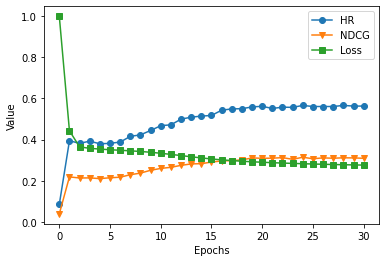

In [ ]:
print("Device available: {}".format(device))

args = parse_args()
path = args.path
dataset = args.dataset
layers = eval(args.layers)
weight_decay = args.weight_decay
num_negatives_train = args.num_neg_train
num_negatives_test = args.num_neg_test
dropout = args.dropout
learner = args.learner
learning_rate = args.lr
batch_size = args.batch_size
epochs = args.epochs
verbose = args.verbose

topK = 10
print("MLP arguments: %s " % (args))
model_out_file = '%s_MLP_%s_%d.h5' %(args.dataset, args.layers, time())

# Load data

t1 = time()
full_dataset = MovieLensDataset(
    path + dataset, num_negatives_train=num_negatives_train, num_negatives_test=num_negatives_test)
train, testRatings, testNegatives = full_dataset.trainMatrix, full_dataset.testRatings, full_dataset.testNegatives
num_users, num_items = train.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d"
      % (time()-t1, num_users, num_items, train.nnz, len(testRatings)))

training_data_generator = DataLoader(
    full_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Build model
model = MLP(num_users, num_items, layers=layers, dropout=dropout)
# Transfer the model to GPU, if one is available
model.to(device)
if verbose:
    print(model)

loss_fn = torch.nn.BCELoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

# Record performance
hr_list = []
ndcg_list = []
BCE_loss_list = []

# Check Init performance
hr, ndcg = test(model, full_dataset, topK)
hr_list.append(hr)
ndcg_list.append(ndcg)
BCE_loss_list.append(1)

# do the epochs now

for epoch in range(epochs):
    epoch_loss = train_one_epoch( model, training_data_generator, loss_fn, optimizer, epoch, device)

    if epoch % verbose == 0:
        hr, ndcg = test(model, full_dataset, topK)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        BCE_loss_list.append(epoch_loss)
        if hr > max(hr_list):
            if args.out > 0:
                model.save(model_out_file, overwrite=True)

print("hr for epochs: ", hr_list)
print("ndcg for epochs: ", ndcg_list)
print("loss for epochs: ", BCE_loss_list)
plot_statistics(hr_list, ndcg_list, BCE_loss_list, model.get_alias(), "/content")
with open("metrics", 'wb') as fp:
    pickle.dump(hr_list, fp)
    pickle.dump(ndcg_list, fp)

best_iter = np.argmax(np.array(hr_list))
best_hr = hr_list[best_iter]
best_ndcg = ndcg_list[best_iter]
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %
      (best_iter, best_hr, best_ndcg))
if args.out > 0:
    print("The best MLP model is saved to %s" %(model_out_file))

Thus far, we keep our focus only on the implicit feedback based matrix factorization model on small movielens dataset. In future, we will be expanding this MVP in the following directions:
1. Large scale industrial datasets - Yoochoose, Trivago
2. Other available models in [this](https://github.com/ShopRunner/collie_recs/tree/main/collie_recs/model) repo
3. Really liked the poster carousel. Put it in dash/streamlit app.

## Training neural factorization model on movielens dataset
> Training MF, MF+bias, and MLP model on movielens-100k dataset in PyTorch.

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef.git

In [ ]:
import torch
import torch.nn.functional as F

from recochef.datasets.synthetic import Synthetic
from recochef.datasets.movielens import MovieLens
from recochef.preprocessing.split import chrono_split
from recochef.preprocessing.encode import label_encode as le
from recochef.models.factorization import MF, MF_bias
from recochef.models.dnn import CollabFNet

In [ ]:
# # generate synthetic implicit data
# synt = Synthetic()
# df = synt.implicit()

movielens = MovieLens()
df = movielens.load_interactions()

# changing rating colname to event following implicit naming conventions
df = df.rename(columns={'RATING': 'EVENT'})

In [ ]:
# drop duplicates
df = df.drop_duplicates()

# chronological split
df_train, df_valid = chrono_split(df, ratio=0.8, min_rating=10)
print(f"Train set:\n\n{df_train}\n{'='*100}\n")
print(f"Validation set:\n\n{df_valid}\n{'='*100}\n")

Train set:

       USERID  ITEMID  EVENT  TIMESTAMP
59972       1     168    5.0  874965478
92487       1     172    5.0  874965478
74577       1     165    5.0  874965518
48214       1     156    4.0  874965556
22971       1     166    5.0  874965677
...       ...     ...    ...        ...
98752     943     139    1.0  888640027
89336     943     426    4.0  888640027
80660     943     720    1.0  888640048
93177     943      80    2.0  888640048
87415     943      53    3.0  888640067

[80000 rows x 4 columns]

Validation set:

       USERID  ITEMID  EVENT  TIMESTAMP
10508       1     208    5.0  878542960
83307       1       3    4.0  878542960
8976        1      12    5.0  878542960
78171       1      58    4.0  878542960
9811        1     201    3.0  878542960
...       ...     ...    ...        ...
81005     943     450    1.0  888693158
92536     943     227    1.0  888693158
95003     943     230    1.0  888693158
94914     943     229    2.0  888693158
92880     943     234   

In [ ]:
# label encoding
df_train, uid_maps = le(df_train, col='USERID')
df_train, iid_maps = le(df_train, col='ITEMID')
df_valid = le(df_valid, col='USERID', maps=uid_maps)
df_valid = le(df_valid, col='ITEMID', maps=iid_maps)

# # event implicit to rating conversion
# event_weights = {'click':1, 'add':2, 'purchase':4}
# event_maps = dict({'EVENT_TO_IDX':event_weights})
# df_train = le(df_train, col='EVENT', maps=event_maps)
# df_valid = le(df_valid, col='EVENT', maps=event_maps)

print(f"Processed Train set:\n\n{df_train}\n{'='*100}\n")
print(f"Processed Validation set:\n\n{df_valid}\n{'='*100}\n")

Processed Train set:

       USERID  ITEMID  EVENT  TIMESTAMP
59972       0       0    5.0  874965478
92487       0       1    5.0  874965478
74577       0       2    5.0  874965518
48214       0       3    4.0  874965556
22971       0       4    5.0  874965677
...       ...     ...    ...        ...
98752     942     933    1.0  888640027
89336     942     990    4.0  888640027
80660     942     643    1.0  888640048
93177     942     155    2.0  888640048
87415     942     166    3.0  888640067

[80000 rows x 4 columns]

Processed Validation set:

       USERID  ITEMID  EVENT  TIMESTAMP
10508       0   341.0    5.0  878542960
83307       0   983.0    4.0  878542960
8976        0   425.0    5.0  878542960
78171       0   639.0    4.0  878542960
9811        0   490.0    3.0  878542960
...       ...     ...    ...        ...
81005     942   314.0    1.0  888693158
92536     942   154.0    1.0  888693158
95003     942   183.0    1.0  888693158
94914     942   176.0    2.0  888693158
9288

In [ ]:
# get number of unique users and items
num_users = len(df_train.USERID.unique())
num_items = len(df_train.ITEMID.unique())

num_users_t = len(df_valid.USERID.unique())
num_items_t = len(df_valid.ITEMID.unique())

print(f"There are {num_users} users and {num_items} items in the train set.\n{'='*100}\n")
print(f"There are {num_users_t} users and {num_items_t} items in the validation set.\n{'='*100}\n")

There are 943 users and 1613 items in the train set.

There are 943 users and 1429 items in the validation set.



In [ ]:
# training and testing related helper functions
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(df_train.USERID.values) # .cuda()
        items = torch.LongTensor(df_train.ITEMID.values) #.cuda()
        ratings = torch.FloatTensor(df_train.EVENT.values) #.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
    test_loss(model, unsqueeze)

def test_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(df_valid.USERID.values) #.cuda()
    items = torch.LongTensor(df_valid.ITEMID.values) #.cuda()
    ratings = torch.FloatTensor(df_valid.EVENT.values) #.cuda()
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())

In [ ]:
# training MF model
model = MF(num_users, num_items, emb_size=100) # .cuda() if you have a GPU
print(f"Training MF model:\n")
train_epocs(model, epochs=10, lr=0.1)
print(f"\n{'='*100}\n")

Training MF model:

13.594555854797363
5.292399883270264
2.558849573135376
3.584117889404297
1.0360910892486572
1.9875222444534302
2.920832633972168
2.4130148887634277
1.2886441946029663
1.112807273864746
test loss 2.085 




In [ ]:
# training MF with bias model
model = MF_bias(num_users, num_items, emb_size=100) #.cuda()
print(f"Training MF+bias model:\n")
train_epocs(model, epochs=10, lr=0.05, wd=1e-5)
print(f"\n{'='*100}\n")

Training MF+bias model:

13.59664535522461
9.730958938598633
4.798837184906006
1.3603413105010986
2.697232723236084
4.214857578277588
2.871798276901245
1.3329992294311523
0.9624974727630615
1.459389328956604
test loss 2.269 




In [ ]:
# training MLP model
model = CollabFNet(num_users, num_items, emb_size=100) #.cuda()
print(f"Training MLP model:\n")
train_epocs(model, epochs=15, lr=0.05, wd=1e-6, unsqueeze=True)
print(f"\n{'='*100}\n")

Training MLP model:

12.962654113769531
1.4028953313827515
15.373563766479492
2.177295207977295
2.6291019916534424
5.752542495727539
6.88251256942749
6.2746357917785645
4.8090314865112305
3.095308303833008
1.6791961193084717
1.1257785558700562
1.678966760635376
2.615834951400757
2.80102276802063
test loss 2.559 




## Neural Matrix Factorization on Movielens
> Experiments with different variations of Neural matrix factorization model in PyTorch on movielens dataset.

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/MovieLens_LatestSmall_ratings.csv")
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
data.shape

(100836, 4)

Data encoding

In [ ]:
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
valid = data[~msk].copy()

In [ ]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [ ]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [ ]:
# encoding the train and validation data
df_train = encode_data(train)
df_valid = encode_data(valid, train)

In [ ]:
df_train.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
6,0,4,5.0,964980868


In [ ]:
df_train.shape

(80450, 4)

In [ ]:
df_valid.head()

,userId,movieId,rating,timestamp
4,0,388,5.0,964982931
5,0,995,3.0,964982400
29,0,841,4.0,964981179
30,0,567,4.0,964982653
32,0,402,4.0,964982546


In [ ]:
df_valid.shape

(19591, 4)

Matrix factorization model

In [ ]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)

In [ ]:
# unit testing the architecture
sample = encode_data(train.sample(5))
display(sample)

,userId,movieId,rating,timestamp
63234,0,0,3.0,961596392
96012,1,1,3.0,840875700
31417,2,2,2.0,955944735
17473,3,3,0.5,1516141230
66983,4,4,4.0,1328232721


In [ ]:
num_users = 5
num_items = 5
emb_size = 3

user_emb = nn.Embedding(num_users, emb_size)
item_emb = nn.Embedding(num_items, emb_size)

users = torch.LongTensor(sample.userId.values)
items = torch.LongTensor(sample.movieId.values)

In [ ]:
U = user_emb(users)
display(U)

tensor([[ 2.2694,  0.9679,  0.3305],
        [-1.1478, -0.7004, -0.8113],
        [-1.2287, -0.7210,  0.3875],
        [ 0.9106,  0.0427, -0.7128],
        [-1.0396, -0.2739,  0.7271]], grad_fn=<EmbeddingBackward>)

In [ ]:
V = item_emb(items)
display(V)

tensor([[-1.9371, -1.1172, -1.5967],
        [-2.4336, -1.1177,  0.6197],
        [ 0.5889,  1.4830, -1.0103],
        [-0.8294,  0.5744, -1.7315],
        [-1.6733, -0.2447, -0.2630]], grad_fn=<EmbeddingBackward>)

In [ ]:
display(U*V) # element wise multiplication

tensor([[-4.3959, -1.0813, -0.5278],
        [ 2.7932,  0.7828, -0.5027],
        [-0.7236, -1.0693, -0.3915],
        [-0.7552,  0.0246,  1.2343],
        [ 1.7397,  0.0670, -0.1912]], grad_fn=<MulBackward0>)

In [ ]:
display((U*V).sum(1))

tensor([-6.0050,  3.0733, -2.1844,  0.5036,  1.6155], grad_fn=<SumBackward1>)

Model training

In [ ]:
num_users = len(df_train.userId.unique())
num_items = len(df_train.movieId.unique())
print("{} users and {} items in the training set".format(num_users, num_items))

610 users and 8998 items in the training set


In [ ]:
model = MF(num_users, num_items, emb_size=100) # .cuda() if you have a GPU

In [ ]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(df_train.userId.values) # .cuda()
        items = torch.LongTensor(df_train.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train.rating.values) #.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
    test_loss(model, unsqueeze)

In [ ]:
def test_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(df_valid.userId.values) #.cuda()
    items = torch.LongTensor(df_valid.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_valid.rating.values) #.cuda()
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())

In [ ]:
train_epocs(model, epochs=10, lr=0.1)

12.914263725280762
4.8582916259765625
2.5804786682128906
3.109440565109253
0.850287139415741
1.819737195968628
2.657919406890869
2.138274908065796
1.0904945135116577
0.9722878932952881
test loss 1.851 


In [ ]:
train_epocs(model, epochs=10, lr=0.01)

1.6430705785751343
1.0046814680099487
0.712002694606781
0.6611021757125854
0.7258523106575012
0.803934633731842
0.843424379825592
0.8351688981056213
0.7928505539894104
0.737376868724823
test loss 0.827 


In [ ]:
train_epocs(model, epochs=10, lr=0.01)

0.6877127289772034
0.6256141066551208
0.6374999284744263
0.6272100210189819
0.6171814799308777
0.614914059638977
0.6113061308860779
0.6033822298049927
0.595890998840332
0.592114269733429
test loss 0.764 


MF with bias

In [ ]:
class MF_bias(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF_bias, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U*V).sum(1) +  b_u  + b_v

In [ ]:
model = MF_bias(num_users, num_items, emb_size=100) #.cuda()

In [ ]:
train_epocs(model, epochs=10, lr=0.05, wd=1e-5)

12.91020393371582
9.150527954101562
4.3840012550354
1.1575191020965576
2.46807861328125
3.7430803775787354
2.4481022357940674
1.0781667232513428
0.816169023513794
1.3183783292770386
test loss 2.069 


In [ ]:
train_epocs(model, epochs=10, lr=0.01, wd=1e-5)

1.8935126066207886
1.3250681161880493
0.9350242614746094
0.7446779012680054
0.722224235534668
0.7774652242660522
0.8231741189956665
0.8222126364707947
0.7816660404205322
0.727698802947998
test loss 0.798 


In [ ]:
train_epocs(model, epochs=10, lr=0.001, wd=1e-5)

0.6853442788124084
0.6711287498474121
0.6592414975166321
0.6495122909545898
0.6417150497436523
0.6356027722358704
0.6309247612953186
0.6274365186691284
0.6249085068702698
0.6231329441070557
test loss 0.751 


Note that these models are susceptible to weight initialization, optimization algorithm and regularization.



### Neural Network Model
Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes. Here we could get better results by keep playing with regularization.

In [ ]:
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [ ]:
model = CollabFNet(num_users, num_items, emb_size=100) #.cuda()

In [ ]:
train_epocs(model, epochs=15, lr=0.05, wd=1e-6, unsqueeze=True)

14.657201766967773
2.586819648742676
6.025796890258789
2.89852237701416
1.1256697177886963
2.0860772132873535
2.9243881702423096
2.806140422821045
1.9981783628463745
1.1265769004821777
0.8947575092315674
1.4373805522918701
1.795198678970337
1.4024922847747803
0.8697773218154907
test loss 0.797 


In [ ]:
train_epocs(model, epochs=10, lr=0.001, wd=1e-6, unsqueeze=True)

0.7495059967041016
0.7382366061210632
0.731941282749176
0.7295416593551636
0.7321946024894714
0.7312469482421875
0.731982409954071
0.7298287153244019
0.7264290452003479
0.7244617938995361
test loss 0.774 


In [ ]:
train_epocs(model, epochs=10, lr=0.001, wd=1e-6, unsqueeze=True)

0.7242854833602905
0.7213587760925293
0.7197834849357605
0.7182263135910034
0.7177621722221375
0.7155387997627258
0.7147852182388306
0.7143447995185852
0.7133223414421082
0.712261974811554
test loss 0.766 


### Neural network model - different approach
> youtube: https://youtu.be/MVB1cbe923A

### Ethan Rosenthal

Ref - https://github.com/EthanRosenthal/torchmf

In [ ]:
import os
import requests
import zipfile
import collections

import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
import torch.multiprocessing as mp
import torch.utils.data as data
from tqdm import tqdm

In [ ]:
def _get_data_path():
    """
    Get path to the movielens dataset file.
    """
    data_path = '/content/data'
    if not os.path.exists(data_path):
        print('Making data path')
        os.mkdir(data_path)
    return data_path


def _download_movielens(dest_path):
    """
    Download the dataset.
    """

    url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    req = requests.get(url, stream=True)

    print('Downloading MovieLens data')

    with open(os.path.join(dest_path, 'ml-100k.zip'), 'wb') as fd:
        for chunk in req.iter_content(chunk_size=None):
            fd.write(chunk)

    with zipfile.ZipFile(os.path.join(dest_path, 'ml-100k.zip'), 'r') as z:
        z.extractall(dest_path)

In [ ]:
def read_movielens_df():
    path = _get_data_path()
    zipfile = os.path.join(path, 'ml-100k.zip')
    if not os.path.isfile(zipfile):
        _download_movielens(path)
    fname = os.path.join(path, 'ml-100k', 'u.data')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(fname, sep='\t', names=names)
    return df


def get_movielens_interactions():
    df = read_movielens_df()

    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]

    interactions = np.zeros((n_users, n_items))
    for row in df.itertuples():
        interactions[row[1] - 1, row[2] - 1] = row[3]
    return interactions


def train_test_split(interactions, n=10):
    """
    Split an interactions matrix into training and test sets.
    Parameters
    ----------
    interactions : np.ndarray
    n : int (default=10)
        Number of items to select / row to place into test.

    Returns
    -------
    train : np.ndarray
    test : np.ndarray
    """
    test = np.zeros(interactions.shape)
    train = interactions.copy()
    for user in range(interactions.shape[0]):
        if interactions[user, :].nonzero()[0].shape[0] > n:
            test_interactions = np.random.choice(interactions[user, :].nonzero()[0],
                                                 size=n,
                                                 replace=False)
            train[user, test_interactions] = 0.
            test[user, test_interactions] = interactions[user, test_interactions]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test


def get_movielens_train_test_split(implicit=False):
    interactions = get_movielens_interactions()
    if implicit:
        interactions = (interactions >= 4).astype(np.float32)
    train, test = train_test_split(interactions)
    train = sp.coo_matrix(train)
    test = sp.coo_matrix(test)
    return train, test

In [ ]:
%%writefile metrics.py

import numpy as np
from sklearn.metrics import roc_auc_score
from torch import multiprocessing as mp
import torch

def get_row_indices(row, interactions):
    start = interactions.indptr[row]
    end = interactions.indptr[row + 1]
    return interactions.indices[start:end]


def auc(model, interactions, num_workers=1):
    aucs = []
    processes = []
    n_users = interactions.shape[0]
    mp_batch = int(np.ceil(n_users / num_workers))

    queue = mp.Queue()
    rows = np.arange(n_users)
    np.random.shuffle(rows)
    for rank in range(num_workers):
        start = rank * mp_batch
        end = np.min((start + mp_batch,  n_users))
        p = mp.Process(target=batch_auc,
                       args=(queue, rows[start:end], interactions, model))
        p.start()
        processes.append(p)

    while True:
        is_alive = False
        for p in processes:
            if p.is_alive():
                is_alive = True
                break
        if not is_alive and queue.empty():
            break

        while not queue.empty():
            aucs.append(queue.get())

    queue.close()
    for p in processes:
        p.join()
    return np.mean(aucs)


def batch_auc(queue, rows, interactions, model):
    n_items = interactions.shape[1]
    items = torch.arange(0, n_items).long()
    users_init = torch.ones(n_items).long()
    for row in rows:
        row = int(row)
        users = users_init.fill_(row)

        preds = model.predict(users, items)
        actuals = get_row_indices(row, interactions)

        if len(actuals) == 0:
            continue
        y_test = np.zeros(n_items)
        y_test[actuals] = 1
        queue.put(roc_auc_score(y_test, preds.data.numpy()))


def patk(model, interactions, num_workers=1, k=5):
    patks = []
    processes = []
    n_users = interactions.shape[0]
    mp_batch = int(np.ceil(n_users / num_workers))

    queue = mp.Queue()
    rows = np.arange(n_users)
    np.random.shuffle(rows)
    for rank in range(num_workers):
        start = rank * mp_batch
        end = np.min((start + mp_batch, n_users))
        p = mp.Process(target=batch_patk,
                       args=(queue, rows[start:end], interactions, model),
                       kwargs={'k': k})
        p.start()
        processes.append(p)

    while True:
        is_alive = False
        for p in processes:
            if p.is_alive():
                is_alive = True
                break
        if not is_alive and queue.empty():
            break

        while not queue.empty():
            patks.append(queue.get())

    queue.close()
    for p in processes:
        p.join()
    return np.mean(patks)


def batch_patk(queue, rows, interactions, model, k=5):
    n_items = interactions.shape[1]

    items = torch.arange(0, n_items).long()
    users_init = torch.ones(n_items).long()
    for row in rows:
        row = int(row)
        users = users_init.fill_(row)

        preds = model.predict(users, items)
        actuals = get_row_indices(row, interactions)

        if len(actuals) == 0:
            continue

        top_k = np.argpartition(-np.squeeze(preds.data.numpy()), k)
        top_k = set(top_k[:k])
        true_pids = set(actuals)
        if true_pids:
            queue.put(len(top_k & true_pids) / float(k))

Writing metrics.py


In [ ]:
import metrics
import importlib
importlib.reload(metrics)

<module 'metrics' from '/content/metrics.py'>

In [ ]:
class Interactions(data.Dataset):
    """
    Hold data in the form of an interactions matrix.
    Typical use-case is like a ratings matrix:
    - Users are the rows
    - Items are the columns
    - Elements of the matrix are the ratings given by a user for an item.
    """

    def __init__(self, mat):
        self.mat = mat.astype(np.float32).tocoo()
        self.n_users = self.mat.shape[0]
        self.n_items = self.mat.shape[1]

    def __getitem__(self, index):
        row = self.mat.row[index]
        col = self.mat.col[index]
        val = self.mat.data[index]
        return (row, col), val

    def __len__(self):
        return self.mat.nnz


class PairwiseInteractions(data.Dataset):
    """
    Sample data from an interactions matrix in a pairwise fashion. The row is
    treated as the main dimension, and the columns are sampled pairwise.
    """

    def __init__(self, mat):
        self.mat = mat.astype(np.float32).tocoo()

        self.n_users = self.mat.shape[0]
        self.n_items = self.mat.shape[1]

        self.mat_csr = self.mat.tocsr()
        if not self.mat_csr.has_sorted_indices:
            self.mat_csr.sort_indices()

    def __getitem__(self, index):
        row = self.mat.row[index]
        found = False

        while not found:
            neg_col = np.random.randint(self.n_items)
            if self.not_rated(row, neg_col, self.mat_csr.indptr,
                              self.mat_csr.indices):
                found = True

        pos_col = self.mat.col[index]
        val = self.mat.data[index]

        return (row, (pos_col, neg_col)), val

    def __len__(self):
        return self.mat.nnz

    @staticmethod
    def not_rated(row, col, indptr, indices):
        # similar to use of bsearch in lightfm
        start = indptr[row]
        end = indptr[row + 1]
        searched = np.searchsorted(indices[start:end], col, 'right')
        if searched >= (end - start):
            # After the array
            return False
        return col != indices[searched]  # Not found

    def get_row_indices(self, row):
        start = self.mat_csr.indptr[row]
        end = self.mat_csr.indptr[row + 1]
        return self.mat_csr.indices[start:end]


class BaseModule(nn.Module):
    """
    Base module for explicit matrix factorization.
    """
    
    def __init__(self,
                 n_users,
                 n_items,
                 n_factors=40,
                 dropout_p=0,
                 sparse=False):
        """

        Parameters
        ----------
        n_users : int
            Number of users
        n_items : int
            Number of items
        n_factors : int
            Number of latent factors (or embeddings or whatever you want to
            call it).
        dropout_p : float
            p in nn.Dropout module. Probability of dropout.
        sparse : bool
            Whether or not to treat embeddings as sparse. NOTE: cannot use
            weight decay on the optimizer if sparse=True. Also, can only use
            Adagrad.
        """
        super(BaseModule, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.user_biases = nn.Embedding(n_users, 1, sparse=sparse)
        self.item_biases = nn.Embedding(n_items, 1, sparse=sparse)
        self.user_embeddings = nn.Embedding(n_users, n_factors, sparse=sparse)
        self.item_embeddings = nn.Embedding(n_items, n_factors, sparse=sparse)
        
        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(p=self.dropout_p)

        self.sparse = sparse
        
    def forward(self, users, items):
        """
        Forward pass through the model. For a single user and item, this
        looks like:

        user_bias + item_bias + user_embeddings.dot(item_embeddings)

        Parameters
        ----------
        users : np.ndarray
            Array of user indices
        items : np.ndarray
            Array of item indices

        Returns
        -------
        preds : np.ndarray
            Predicted ratings.

        """
        ues = self.user_embeddings(users)
        uis = self.item_embeddings(items)

        preds = self.user_biases(users)
        preds += self.item_biases(items)
        preds += (self.dropout(ues) * self.dropout(uis)).sum(dim=1, keepdim=True)

        return preds.squeeze()
    
    def __call__(self, *args):
        return self.forward(*args)

    def predict(self, users, items):
        return self.forward(users, items)


def bpr_loss(preds, vals):
    sig = nn.Sigmoid()
    return (1.0 - sig(preds)).pow(2).sum()


class BPRModule(nn.Module):
    
    def __init__(self,
                 n_users,
                 n_items,
                 n_factors=40,
                 dropout_p=0,
                 sparse=False,
                 model=BaseModule):
        super(BPRModule, self).__init__()

        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.dropout_p = dropout_p
        self.sparse = sparse
        self.pred_model = model(
            self.n_users,
            self.n_items,
            n_factors=n_factors,
            dropout_p=dropout_p,
            sparse=sparse
        )

    def forward(self, users, items):
        assert isinstance(items, tuple), \
            'Must pass in items as (pos_items, neg_items)'
        # Unpack
        (pos_items, neg_items) = items
        pos_preds = self.pred_model(users, pos_items)
        neg_preds = self.pred_model(users, neg_items)
        return pos_preds - neg_preds

    def predict(self, users, items):
        return self.pred_model(users, items)


class BasePipeline:
    """
    Class defining a training pipeline. Instantiates data loaders, model,
    and optimizer. Handles training for multiple epochs and keeping track of
    train and test loss.
    """

    def __init__(self,
                 train,
                 test=None,
                 model=BaseModule,
                 n_factors=40,
                 batch_size=32,
                 dropout_p=0.02,
                 sparse=False,
                 lr=0.01,
                 weight_decay=0.,
                 optimizer=torch.optim.Adam,
                 loss_function=nn.MSELoss(reduction='sum'),
                 n_epochs=10,
                 verbose=False,
                 random_seed=None,
                 interaction_class=Interactions,
                 hogwild=False,
                 num_workers=0,
                 eval_metrics=None,
                 k=5):
        self.train = train
        self.test = test

        if hogwild:
            num_loader_workers = 0
        else:
            num_loader_workers = num_workers
        self.train_loader = data.DataLoader(
            interaction_class(train), batch_size=batch_size, shuffle=True,
            num_workers=num_loader_workers)
        if self.test is not None:
            self.test_loader = data.DataLoader(
                interaction_class(test), batch_size=batch_size, shuffle=True,
                num_workers=num_loader_workers)
        self.num_workers = num_workers
        self.n_users = self.train.shape[0]
        self.n_items = self.train.shape[1]
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.dropout_p = dropout_p
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_function = loss_function
        self.n_epochs = n_epochs
        if sparse:
            assert weight_decay == 0.0
        self.model = model(self.n_users,
                           self.n_items,
                           n_factors=self.n_factors,
                           dropout_p=self.dropout_p,
                           sparse=sparse)
        self.optimizer = optimizer(self.model.parameters(),
                                   lr=self.lr,
                                   weight_decay=self.weight_decay)
        self.warm_start = False
        self.losses = collections.defaultdict(list)
        self.verbose = verbose
        self.hogwild = hogwild
        if random_seed is not None:
            if self.hogwild:
                random_seed += os.getpid()
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)

        if eval_metrics is None:
            eval_metrics = []
        self.eval_metrics = eval_metrics
        self.k = k

    def break_grads(self):
        for param in self.model.parameters():
            # Break gradient sharing
            if param.grad is not None:
                param.grad.data = param.grad.data.clone()

    def fit(self):
        for epoch in range(1, self.n_epochs + 1):

            if self.hogwild:
                self.model.share_memory()
                processes = []
                train_losses = []
                queue = mp.Queue()
                for rank in range(self.num_workers):
                    p = mp.Process(target=self._fit_epoch,
                                   kwargs={'epoch': epoch,
                                           'queue': queue})
                    p.start()
                    processes.append(p)
                for p in processes:
                    p.join()

                while True:
                    is_alive = False
                    for p in processes:
                        if p.is_alive():
                            is_alive = True
                            break
                    if not is_alive and queue.empty():
                        break

                    while not queue.empty():
                        train_losses.append(queue.get())
                queue.close()
                train_loss = np.mean(train_losses)
            else:
                train_loss = self._fit_epoch(epoch)

            self.losses['train'].append(train_loss)
            row = 'Epoch: {0:^3}  train: {1:^10.5f}'.format(epoch, self.losses['train'][-1])
            if self.test is not None:
                self.losses['test'].append(self._validation_loss())
                row += 'val: {0:^10.5f}'.format(self.losses['test'][-1])
                for metric in self.eval_metrics:
                    func = getattr(metrics, metric)
                    res = func(self.model, self.test_loader.dataset.mat_csr,
                               num_workers=self.num_workers)
                    self.losses['eval-{}'.format(metric)].append(res)
                    row += 'eval-{0}: {1:^10.5f}'.format(metric, res)
            self.losses['epoch'].append(epoch)
            if self.verbose:
                print(row)

    def _fit_epoch(self, epoch=1, queue=None):
        if self.hogwild:
            self.break_grads()

        self.model.train()
        total_loss = torch.Tensor([0])
        pbar = tqdm(enumerate(self.train_loader),
                    total=len(self.train_loader),
                    desc='({0:^3})'.format(epoch))
        for batch_idx, ((row, col), val) in pbar:
            self.optimizer.zero_grad()

            row = row.long()
            # TODO: turn this into a collate_fn like the data_loader
            if isinstance(col, list):
                col = tuple(c.long() for c in col)
            else:
                col = col.long()
            val = val.float()

            preds = self.model(row, col)
            loss = self.loss_function(preds, val)
            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()
            batch_loss = loss.item() / row.size()[0]
            pbar.set_postfix(train_loss=batch_loss)
        total_loss /= self.train.nnz
        if queue is not None:
            queue.put(total_loss[0])
        else:
            return total_loss[0]

    def _validation_loss(self):
        self.model.eval()
        total_loss = torch.Tensor([0])
        for batch_idx, ((row, col), val) in enumerate(self.test_loader):
            row = row.long()
            if isinstance(col, list):
                col = tuple(c.long() for c in col)
            else:
                col = col.long()
            val = val.float()

            preds = self.model(row, col)
            loss = self.loss_function(preds, val)
            total_loss += loss.item()

        total_loss /= self.test.nnz
        return total_loss[0]

In [ ]:
def explicit():
    train, test = get_movielens_train_test_split()
    pipeline = BasePipeline(train, test=test, model=BaseModule,
                            n_factors=10, batch_size=1024, dropout_p=0.02,
                            lr=0.02, weight_decay=0.1,
                            optimizer=torch.optim.Adam, n_epochs=40,
                            verbose=True, random_seed=2017)
    pipeline.fit()


def implicit():
    train, test = get_movielens_train_test_split(implicit=True)

    pipeline = BasePipeline(train, test=test, verbose=True,
                           batch_size=1024, num_workers=4,
                           n_factors=20, weight_decay=0,
                           dropout_p=0., lr=.2, sparse=True,
                           optimizer=torch.optim.SGD, n_epochs=40,
                           random_seed=2017, loss_function=bpr_loss,
                           model=BPRModule,
                           interaction_class=PairwiseInteractions,
                           eval_metrics=('auc', 'patk'))
    pipeline.fit()


def hogwild():
    train, test = get_movielens_train_test_split(implicit=True)

    pipeline = BasePipeline(train, test=test, verbose=True,
                            batch_size=1024, num_workers=4,
                            n_factors=20, weight_decay=0,
                            dropout_p=0., lr=.2, sparse=True,
                            optimizer=torch.optim.SGD, n_epochs=40,
                            random_seed=2017, loss_function=bpr_loss,
                            model=BPRModule, hogwild=True,
                            interaction_class=PairwiseInteractions,
                            eval_metrics=('auc', 'patk'))
    pipeline.fit()

In [ ]:
explicit()

Making data path


( 2 ):   7%|▋         | 6/89 [00:00<00:01, 57.03it/s, train_loss=6.06]

Epoch:  1   train:  14.42120 val:  8.68083  


( 3 ):   8%|▊         | 7/89 [00:00<00:01, 62.84it/s, train_loss=2.23]

Epoch:  2   train:  4.15028  val:  3.99969  


( 4 ):   7%|▋         | 6/89 [00:00<00:01, 59.43it/s, train_loss=1.33]

Epoch:  3   train:  1.84903  val:  2.41240  


( 5 ):   8%|▊         | 7/89 [00:00<00:01, 61.59it/s, train_loss=0.982]

Epoch:  4   train:  1.20266  val:  1.78271  


( 6 ):   8%|▊         | 7/89 [00:00<00:01, 62.99it/s, train_loss=0.861]

Epoch:  5   train:  0.98022  val:  1.48147  


( 7 ):   8%|▊         | 7/89 [00:00<00:01, 65.11it/s, train_loss=0.77] 

Epoch:  6   train:  0.88477  val:  1.32482  


( 8 ):   7%|▋         | 6/89 [00:00<00:01, 54.86it/s, train_loss=0.766]

Epoch:  7   train:  0.83306  val:  1.22818  


( 9 ):   3%|▎         | 3/89 [00:00<00:03, 25.32it/s, train_loss=0.722]

Epoch:  8   train:  0.80015  val:  1.16457  


(10 ):   2%|▏         | 2/89 [00:00<00:04, 19.07it/s, train_loss=0.708]

Epoch:  9   train:  0.77529  val:  1.12250  


(11 ):   2%|▏         | 2/89 [00:00<00:04, 19.87it/s, train_loss=0.735]

Epoch: 10   train:  0.75322  val:  1.09408  


(12 ):   8%|▊         | 7/89 [00:00<00:01, 62.74it/s, train_loss=0.655]

Epoch: 11   train:  0.73431  val:  1.06755  


(13 ):   8%|▊         | 7/89 [00:00<00:01, 61.52it/s, train_loss=0.706]

Epoch: 12   train:  0.71816  val:  1.05441  


(14 ):   7%|▋         | 6/89 [00:00<00:01, 57.44it/s, train_loss=0.658]

Epoch: 13   train:  0.70331  val:  1.04291  


(15 ):   7%|▋         | 6/89 [00:00<00:01, 55.63it/s, train_loss=0.662]

Epoch: 14   train:  0.69230  val:  1.03409  


(16 ):   8%|▊         | 7/89 [00:00<00:01, 63.50it/s, train_loss=0.648]

Epoch: 15   train:  0.68174  val:  1.02946  


(17 ):   8%|▊         | 7/89 [00:00<00:01, 66.62it/s, train_loss=0.6]  

Epoch: 16   train:  0.67185  val:  1.02574  


(18 ):   7%|▋         | 6/89 [00:00<00:01, 59.98it/s, train_loss=0.647]

Epoch: 17   train:  0.66559  val:  1.01690  


(19 ):   7%|▋         | 6/89 [00:00<00:01, 58.13it/s, train_loss=0.609]

Epoch: 18   train:  0.65754  val:  1.01814  


(20 ):   8%|▊         | 7/89 [00:00<00:01, 64.70it/s, train_loss=0.636]

Epoch: 19   train:  0.65179  val:  1.01196  


(21 ):   8%|▊         | 7/89 [00:00<00:01, 68.79it/s, train_loss=0.607]

Epoch: 20   train:  0.64911  val:  1.00926  


(22 ):   7%|▋         | 6/89 [00:00<00:01, 52.77it/s, train_loss=0.635]

Epoch: 21   train:  0.64537  val:  1.01296  


(23 ):   4%|▍         | 4/89 [00:00<00:02, 39.91it/s, train_loss=0.588]

Epoch: 22   train:  0.64303  val:  1.00838  


(24 ):   7%|▋         | 6/89 [00:00<00:01, 59.61it/s, train_loss=0.633]

Epoch: 23   train:  0.63932  val:  0.99910  


(25 ):   7%|▋         | 6/89 [00:00<00:01, 52.67it/s, train_loss=0.594]

Epoch: 24   train:  0.63549  val:  1.01004  


(26 ):   7%|▋         | 6/89 [00:00<00:01, 58.84it/s, train_loss=0.59] 

Epoch: 25   train:  0.63468  val:  1.00146  


(27 ):   7%|▋         | 6/89 [00:00<00:01, 58.98it/s, train_loss=0.603]

Epoch: 26   train:  0.63316  val:  1.00257  


(28 ):   8%|▊         | 7/89 [00:00<00:01, 67.37it/s, train_loss=0.584]

Epoch: 27   train:  0.63269  val:  1.00099  


(29 ):   7%|▋         | 6/89 [00:00<00:01, 57.41it/s, train_loss=0.573]

Epoch: 28   train:  0.63194  val:  0.99549  


(30 ):   7%|▋         | 6/89 [00:00<00:01, 58.95it/s, train_loss=0.564]

Epoch: 29   train:  0.63050  val:  1.00029  


(31 ):   8%|▊         | 7/89 [00:00<00:01, 65.42it/s, train_loss=0.563]

Epoch: 30   train:  0.63016  val:  0.99232  


(32 ):   8%|▊         | 7/89 [00:00<00:01, 62.85it/s, train_loss=0.58] 

Epoch: 31   train:  0.63022  val:  0.99609  


(33 ):   7%|▋         | 6/89 [00:00<00:01, 59.53it/s, train_loss=0.576]

Epoch: 32   train:  0.63043  val:  0.99635  


(34 ):   8%|▊         | 7/89 [00:00<00:01, 64.98it/s, train_loss=0.625]

Epoch: 33   train:  0.63210  val:  0.99697  


(35 ):   6%|▌         | 5/89 [00:00<00:01, 49.84it/s, train_loss=0.546]

Epoch: 34   train:  0.63177  val:  0.99458  


(36 ):   7%|▋         | 6/89 [00:00<00:01, 57.96it/s, train_loss=0.543]

Epoch: 35   train:  0.63137  val:  1.00267  


(37 ):   7%|▋         | 6/89 [00:00<00:01, 59.93it/s, train_loss=0.553]

Epoch: 36   train:  0.63002  val:  0.99718  


(38 ):   7%|▋         | 6/89 [00:00<00:01, 57.61it/s, train_loss=0.56]

Epoch: 37   train:  0.62959  val:  0.99938  


(39 ):   8%|▊         | 7/89 [00:00<00:01, 61.75it/s, train_loss=0.599]

Epoch: 38   train:  0.63083  val:  1.00133  


(40 ):   8%|▊         | 7/89 [00:00<00:01, 60.35it/s, train_loss=0.573]

Epoch: 39   train:  0.63185  val:  0.99541  


(40 ): 100%|██████████| 89/89 [00:01<00:00, 61.02it/s, train_loss=0.69]


Epoch: 40   train:  0.63168  val:  0.99467  


In [ ]:
implicit()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
( 1 ): 100%|██████████| 46/46 [00:02<00:00, 21.50it/s, train_loss=0.361]


Epoch:  1   train:  0.42040  val:  0.40008  eval-auc:  0.55278  eval-patk:  0.00776  


( 2 ): 100%|██████████| 46/46 [00:02<00:00, 22.72it/s, train_loss=0.298]


Epoch:  2   train:  0.34066  val:  0.35044  eval-auc:  0.60807  eval-patk:  0.01164  


( 3 ): 100%|██████████| 46/46 [00:02<00:00, 22.89it/s, train_loss=0.303]


Epoch:  3   train:  0.27492  val:  0.31180  eval-auc:  0.65543  eval-patk:  0.01804  


( 4 ): 100%|██████████| 46/46 [00:01<00:00, 23.75it/s, train_loss=0.192]


Epoch:  4   train:  0.22703  val:  0.29160  eval-auc:  0.69006  eval-patk:  0.02694  


( 5 ): 100%|██████████| 46/46 [00:02<00:00, 21.58it/s, train_loss=0.17]


Epoch:  5   train:  0.19465  val:  0.27365  eval-auc:  0.71412  eval-patk:  0.03265  


( 6 ): 100%|██████████| 46/46 [00:02<00:00, 22.30it/s, train_loss=0.176]


Epoch:  6   train:  0.17487  val:  0.25775  eval-auc:  0.73276  eval-patk:  0.03973  


( 7 ): 100%|██████████| 46/46 [00:02<00:00, 22.14it/s, train_loss=0.202]


Epoch:  7   train:  0.16267  val:  0.25430  eval-auc:  0.74666  eval-patk:  0.04201  


( 8 ): 100%|██████████| 46/46 [00:02<00:00, 22.22it/s, train_loss=0.17]


Epoch:  8   train:  0.15176  val:  0.24547  eval-auc:  0.75858  eval-patk:  0.04429  


( 9 ): 100%|██████████| 46/46 [00:02<00:00, 22.55it/s, train_loss=0.141]


Epoch:  9   train:  0.14359  val:  0.23771  eval-auc:  0.76822  eval-patk:  0.04589  


(10 ): 100%|██████████| 46/46 [00:01<00:00, 23.32it/s, train_loss=0.151]


Epoch: 10   train:  0.13715  val:  0.22593  eval-auc:  0.77713  eval-patk:  0.04361  


(11 ): 100%|██████████| 46/46 [00:01<00:00, 23.04it/s, train_loss=0.115]


Epoch: 11   train:  0.13167  val:  0.22131  eval-auc:  0.78402  eval-patk:  0.04772  


(12 ): 100%|██████████| 46/46 [00:02<00:00, 22.63it/s, train_loss=0.134]


Epoch: 12   train:  0.12781  val:  0.22118  eval-auc:  0.79055  eval-patk:  0.04749  


(13 ): 100%|██████████| 46/46 [00:01<00:00, 23.33it/s, train_loss=0.128]


Epoch: 13   train:  0.12185  val:  0.21263  eval-auc:  0.79726  eval-patk:  0.05228  


(14 ): 100%|██████████| 46/46 [00:02<00:00, 22.32it/s, train_loss=0.109]


Epoch: 14   train:  0.11865  val:  0.20135  eval-auc:  0.80326  eval-patk:  0.04977  


(15 ): 100%|██████████| 46/46 [00:01<00:00, 23.13it/s, train_loss=0.117]


Epoch: 15   train:  0.11352  val:  0.20501  eval-auc:  0.80805  eval-patk:  0.05434  


(16 ): 100%|██████████| 46/46 [00:01<00:00, 23.17it/s, train_loss=0.113]


Epoch: 16   train:  0.11156  val:  0.20189  eval-auc:  0.81208  eval-patk:  0.05753  


(17 ): 100%|██████████| 46/46 [00:02<00:00, 22.15it/s, train_loss=0.127]


Epoch: 17   train:  0.10898  val:  0.19678  eval-auc:  0.81534  eval-patk:  0.05936  


(18 ): 100%|██████████| 46/46 [00:01<00:00, 23.03it/s, train_loss=0.13]


Epoch: 18   train:  0.10363  val:  0.19250  eval-auc:  0.81967  eval-patk:  0.05890  


(19 ): 100%|██████████| 46/46 [00:02<00:00, 22.78it/s, train_loss=0.121]


Epoch: 19   train:  0.10260  val:  0.18791  eval-auc:  0.82216  eval-patk:  0.06416  


(20 ): 100%|██████████| 46/46 [00:02<00:00, 22.97it/s, train_loss=0.121]


Epoch: 20   train:  0.10081  val:  0.18382  eval-auc:  0.82357  eval-patk:  0.06370  


(21 ): 100%|██████████| 46/46 [00:02<00:00, 22.89it/s, train_loss=0.0978]


Epoch: 21   train:  0.09957  val:  0.18360  eval-auc:  0.82604  eval-patk:  0.06667  


(22 ): 100%|██████████| 46/46 [00:02<00:00, 22.88it/s, train_loss=0.105]


Epoch: 22   train:  0.09936  val:  0.17989  eval-auc:  0.82805  eval-patk:  0.06667  


(23 ): 100%|██████████| 46/46 [00:01<00:00, 23.03it/s, train_loss=0.102]


Epoch: 23   train:  0.09896  val:  0.17684  eval-auc:  0.83031  eval-patk:  0.07123  


(24 ): 100%|██████████| 46/46 [00:01<00:00, 23.09it/s, train_loss=0.116]


Epoch: 24   train:  0.09503  val:  0.18290  eval-auc:  0.83277  eval-patk:  0.06758  


(25 ): 100%|██████████| 46/46 [00:02<00:00, 22.64it/s, train_loss=0.081]


Epoch: 25   train:  0.09565  val:  0.17506  eval-auc:  0.83462  eval-patk:  0.07511  


(26 ): 100%|██████████| 46/46 [00:02<00:00, 22.48it/s, train_loss=0.102]


Epoch: 26   train:  0.09337  val:  0.17530  eval-auc:  0.83571  eval-patk:  0.07169  


(27 ): 100%|██████████| 46/46 [00:02<00:00, 21.46it/s, train_loss=0.0837]


Epoch: 27   train:  0.09035  val:  0.17689  eval-auc:  0.83655  eval-patk:  0.07420  


(28 ): 100%|██████████| 46/46 [00:02<00:00, 20.81it/s, train_loss=0.0846]


Epoch: 28   train:  0.08635  val:  0.17874  eval-auc:  0.83849  eval-patk:  0.07420  


(29 ): 100%|██████████| 46/46 [00:02<00:00, 21.13it/s, train_loss=0.107]


Epoch: 29   train:  0.08961  val:  0.17910  eval-auc:  0.83905  eval-patk:  0.07237  


(30 ): 100%|██████████| 46/46 [00:02<00:00, 21.09it/s, train_loss=0.0935]


Epoch: 30   train:  0.08822  val:  0.17294  eval-auc:  0.84065  eval-patk:  0.07717  


(31 ): 100%|██████████| 46/46 [00:02<00:00, 21.52it/s, train_loss=0.0926]


Epoch: 31   train:  0.08964  val:  0.16762  eval-auc:  0.84098  eval-patk:  0.07466  


(32 ): 100%|██████████| 46/46 [00:02<00:00, 21.57it/s, train_loss=0.0708]


Epoch: 32   train:  0.08982  val:  0.16215  eval-auc:  0.84217  eval-patk:  0.07055  


(33 ): 100%|██████████| 46/46 [00:02<00:00, 20.14it/s, train_loss=0.106]


Epoch: 33   train:  0.08753  val:  0.16941  eval-auc:  0.84282  eval-patk:  0.07352  


(34 ): 100%|██████████| 46/46 [00:02<00:00, 20.73it/s, train_loss=0.0781]


Epoch: 34   train:  0.08659  val:  0.17334  eval-auc:  0.84284  eval-patk:  0.07489  


(35 ): 100%|██████████| 46/46 [00:02<00:00, 20.66it/s, train_loss=0.0971]


Epoch: 35   train:  0.08623  val:  0.17476  eval-auc:  0.84393  eval-patk:  0.07443  


(36 ): 100%|██████████| 46/46 [00:02<00:00, 20.77it/s, train_loss=0.0864]


Epoch: 36   train:  0.08559  val:  0.17291  eval-auc:  0.84470  eval-patk:  0.07397  


(37 ): 100%|██████████| 46/46 [00:02<00:00, 20.11it/s, train_loss=0.0751]


Epoch: 37   train:  0.08506  val:  0.16872  eval-auc:  0.84690  eval-patk:  0.07648  


(38 ): 100%|██████████| 46/46 [00:02<00:00, 18.27it/s, train_loss=0.0964]


Epoch: 38   train:  0.08522  val:  0.16541  eval-auc:  0.84715  eval-patk:  0.07991  


(39 ): 100%|██████████| 46/46 [00:02<00:00, 19.55it/s, train_loss=0.0962]


Epoch: 39   train:  0.08316  val:  0.16021  eval-auc:  0.84812  eval-patk:  0.07991  


(40 ): 100%|██████████| 46/46 [00:02<00:00, 19.17it/s, train_loss=0.0943]


Epoch: 40   train:  0.08459  val:  0.16542  eval-auc:  0.84809  eval-patk:  0.07237  


## Neural Graph Collaborative Filtering on MovieLens
> Applying NGCF PyTorch version on Movielens-100k.

### Libraries

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef

In [ ]:
import os
import csv 
import argparse
import numpy as np
import pandas as pd
import random as rd
from time import time
from pathlib import Path
import scipy.sparse as sp
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F

from recochef.preprocessing.split import chrono_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

### Data Loading

The MovieLens 100K data set consists of 100,000 ratings from 1000 users on 1700 movies as described on [their website](https://grouplens.org/datasets/movielens/100k/).

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [ ]:
!unzip ml-100k.zip

In [ ]:
df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['USERID','ITEMID','RATING','TIMESTAMP'])
df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Train/Test Split

We split the data chronologically in 80:20 ratio. Validated the split for user 4.

In [ ]:
df_train, df_test = chrono_split(df, ratio=0.8)

In [ ]:
userid = 4

query = "USERID==@userid"
display(df.query(query))
display(df_train.query(query))
display(df_test.query(query))

,USERID,ITEMID,RATING,TIMESTAMP
1250,4,264,3,892004275
1329,4,303,5,892002352
2204,4,361,5,892002353
2526,4,357,4,892003525
3277,4,260,4,892004275
5960,4,356,3,892003459
12151,4,294,5,892004409
13893,4,288,4,892001445
16305,4,50,5,892003526
18930,4,354,5,892002353


,USERID,ITEMID,RATING,TIMESTAMP
24743,4,258,5,892001374
13893,4,288,4,892001445
20383,4,300,5,892001445
24519,4,328,3,892001537
20082,4,271,4,892001690
68273,4,359,5,892002352
71055,4,362,5,892002352
1329,4,303,5,892002352
51203,4,327,5,892002352
35313,4,329,5,892002352


,USERID,ITEMID,RATING,TIMESTAMP
76722,4,358,2,892004275
3277,4,260,4,892004275
1250,4,264,3,892004275
12151,4,294,5,892004409
48826,4,11,4,892004520


### Preprocessing

1. Sort by User ID and Timestamp
2. Label encode user and item id - in this case, already label encoded starting from 1, so decreasing ids by 1 as a proxy for label encode
3. Remove Timestamp and Rating column. The reason is that we are training a recall-maximing model where the objective is to correctly retrieve the items that users can interact with. We can select a rating threshold also
4. Convert Item IDs into list format
5. Store as a space-seperated txt file

In [ ]:
def preprocess(data):
  data = data.copy()
  data = data.sort_values(by=['USERID','TIMESTAMP'])
  data['USERID'] = data['USERID'] - 1
  data['ITEMID'] = data['ITEMID'] - 1
  data.drop(['TIMESTAMP','RATING'], axis=1, inplace=True)
  data = data.groupby('USERID')['ITEMID'].apply(list).reset_index(name='ITEMID')
  return data

In [ ]:
preprocess(df_train).head()

,USERID,ITEMID
0,0,"[167, 171, 164, 155, 165, 195, 186, 13, 249, 1..."
1,1,"[285, 257, 304, 306, 287, 311, 300, 305, 291, ..."
2,2,"[301, 332, 343, 299, 267, 336, 302, 344, 353, ..."
3,3,"[257, 287, 299, 327, 270, 358, 361, 302, 326, ..."
4,4,"[266, 454, 221, 120, 404, 362, 256, 249, 24, 2..."


In [ ]:
def store(data, target_file='./data/movielens/train.txt'):
  Path(target_file).parent.mkdir(parents=True, exist_ok=True)
  with open(target_file, 'w+') as f:
    writer = csv.writer(f, delimiter=' ')
    for USERID, row in zip(data.USERID.values,data.ITEMID.values):
      row = [USERID] + row
      writer.writerow(row)

In [ ]:
store(preprocess(df_train), '/content/data/ml-100k/train.txt')
store(preprocess(df_test), '/content/data/ml-100k/test.txt')

In [ ]:
!head /content/data/ml-100k/train.txt

0 167 171 164 155 165 195 186 13 249 126 180 116 108 0 245 256 247 49 248 252 261 92 223 123 18 122 136 145 6 234 14 244 259 23 263 125 236 12 24 120 250 235 239 117 129 64 189 46 30 27 113 38 51 237 198 182 10 68 160 94 59 82 178 21 97 63 134 162 25 201 88 7 213 181 47 98 159 174 191 179 127 142 184 67 54 203 55 95 80 78 150 211 22 69 83 93 196 190 183 133 206 144 187 185 96 84 35 143 158 16 173 251 104 147 107 146 219 105 242 121 106 103 246 119 44 267 266 258 260 262 9 149 233 91 70 41 175 90 192 216 176 215 193 72 58 132 40 194 217 169 212 156 222 26 226 79 230 66 118 199 3 214 163 1 205 76 52 135 45 39 152 268 253 114 172 210 228 154 202 61 89 218 166 229 34 161 60 264 111 56 48 29 232 130 151 81 140 71 32 157 197 224 112 20 148 87 100 109 102 238 33 28 42 131 209 204 115 124
1 285 257 304 306 287 311 300 305 291 302 268 298 314 295 0 18 296 292 274 256 294 276 286 254 297 289 279 273 275 272 290 277 293 24 278 13 110 9 281 12 236 283 99 126 312 284 301 282 250 310
2 301 332 343 2

In [ ]:
!head /content/data/ml-100k/test.txt

0 207 2 11 57 200 137 65 36 37 139 240 75 225 77 62 231 138 141 74 50 53 43 86 99 8 227 153 85 168 15 177 221 257 265 254 271 270 19 128 220 243 5 17 269 208 31 188 241 170 110 4 255 101 73
1 49 241 271 309 303 299 288 315 307 308 313 280
2 320 327 326 345 347 259 330 317 316 319 180
3 357 259 263 293 10
4 138 388 453 68 161 232 242 258 451 439 437 436 438 188 168 407 100 425 376 62 399 93 408 193 162 393 375 39 409 23 441 387 394 452 456
5 516 80 133 498 194 466 418 131 504 207 356 465 199 172 187 212 273 422 169 525 484 508 515 501 201 469 366 185 500 153 477 202 167 424 18 85 152 27 517 538 464 271
6 675 61 144 551 616 560 569 553 585 540 52 138 589 448 544 558 333 293 259 624 417 541 557 218 671 439 568 562 550 564 566 668 445 637 556 579 665 641 226 582 53 573 449 142 416 625 620 559 230 575 390 539 427 174 72 584 574 576 385 578 519 386 316 661 552 554 30 133 323 257 11 192 640 184 198 356 666 653 432 581 340
7 549 81 187 221 430 683 517 226 240 232 565 684
8 690 285 482 486
9 14

In [ ]:
Path('/content/results').mkdir(parents=True, exist_ok=True)

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run NGCF.")
    parser.add_argument('--data_dir', type=str,
                        default='./data/',
                        help='Input data path.')
    parser.add_argument('--dataset', type=str, default='ml-100k',
                        help='Dataset name: Amazond-book, Gowella, ml-100k')
    parser.add_argument('--results_dir', type=str, default='results',
                        help='Store model to path.')
    parser.add_argument('--n_epochs', type=int, default=400,
                        help='Number of epoch.')
    parser.add_argument('--reg', type=float, default=1e-5,
                        help='l2 reg.')
    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate.')
    parser.add_argument('--emb_dim', type=int, default=64,
                        help='number of embeddings.')
    parser.add_argument('--layers', type=str, default='[64,64]',
                        help='Output sizes of every layer')
    parser.add_argument('--batch_size', type=int, default=512,
                        help='Batch size.')
    parser.add_argument('--node_dropout', type=float, default=0.,
                        help='Graph Node dropout.')
    parser.add_argument('--mess_dropout', type=float, default=0.1,
                        help='Message dropout.')
    parser.add_argument('--k', type=str, default=20,
                        help='k order of metric evaluation (e.g. NDCG@k)')
    parser.add_argument('--eval_N', type=int, default=5,
                        help='Evaluate every N epochs')
    parser.add_argument('--save_results', type=int, default=1,
                        help='Save model and results')

    return parser.parse_args(args={})

### Helper Functions

- early_stopping()
- train()
- split_matrix()
- ndcg_k()
- eval_model

#### Early Stopping
Premature stopping is applied if *recall@20* on the test set does not increase for 5 successive epochs.

In [ ]:
def early_stopping(log_value, best_value, stopping_step, flag_step, expected_order='asc'):
    """
    Check if early_stopping is needed
    Function copied from original code
    """
    assert expected_order in ['asc', 'des']
    if (expected_order == 'asc' and log_value >= best_value) or (expected_order == 'des' and log_value <= best_value):
        stopping_step = 0
        best_value = log_value
    else:
        stopping_step += 1

    if stopping_step >= flag_step:
        print("Early stopping at step: {} log:{}".format(flag_step, log_value))
        should_stop = True
    else:
        should_stop = False

    return best_value, stopping_step, should_stop

In [ ]:
def train(model, data_generator, optimizer):
    """
    Train the model PyTorch style
    Arguments:
    ---------
    model: PyTorch model
    data_generator: Data object
    optimizer: PyTorch optimizer
    """
    model.train()
    n_batch = data_generator.n_train // data_generator.batch_size + 1
    running_loss=0
    for _ in range(n_batch):
        u, i, j = data_generator.sample()
        optimizer.zero_grad()
        loss = model(u,i,j)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss

def split_matrix(X, n_splits=100):
    """
    Split a matrix/Tensor into n_folds (for the user embeddings and the R matrices)
    Arguments:
    ---------
    X: matrix to be split
    n_folds: number of folds
    Returns:
    -------
    splits: split matrices
    """
    splits = []
    chunk_size = X.shape[0] // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = X.shape[0] if i == n_splits - 1 else (i + 1) * chunk_size
        splits.append(X[start:end])
    return splits

def compute_ndcg_k(pred_items, test_items, test_indices, k):
    """
    Compute NDCG@k
    
    Arguments:
    ---------
    pred_items: binary tensor with 1s in those locations corresponding to the predicted item interactions
    test_items: binary tensor with 1s in locations corresponding to the real test interactions
    test_indices: tensor with the location of the top-k predicted items
    k: k'th-order 
    Returns:
    -------
    NDCG@k
    """
    r = (test_items * pred_items).gather(1, test_indices)
    f = torch.from_numpy(np.log2(np.arange(2, k+2))).float().cuda()
    dcg = (r[:, :k]/f).sum(1)
    dcg_max = (torch.sort(r, dim=1, descending=True)[0][:, :k]/f).sum(1)
    ndcg = dcg/dcg_max
    ndcg[torch.isnan(ndcg)] = 0
    return ndcg

#### Eval Model

At every N epoch, the model is evaluated on the test set. From this evaluation, we compute the recall and normal discounted cumulative gain (ndcg) at the top-20 predictions. It is important to note that in order to evaluate the model on the test set we have to ‘unpack’ the sparse matrix (torch.sparse.todense()), and thus load a bunch of ‘zeros’ on memory. In order to prevent memory overload, we split the sparse matrices into 100 chunks, unpack the sparse chunks one by one, compute the metrics we need, and compute the mean value of all chunks.

In [ ]:
def eval_model(u_emb, i_emb, Rtr, Rte, k):
    """
    Evaluate the model
    
    Arguments:
    ---------
    u_emb: User embeddings
    i_emb: Item embeddings
    Rtr: Sparse matrix with the training interactions
    Rte: Sparse matrix with the testing interactions
    k : kth-order for metrics
    
    Returns:
    --------
    result: Dictionary with lists correponding to the metrics at order k for k in Ks
    """
    # split matrices
    ue_splits = split_matrix(u_emb)
    tr_splits = split_matrix(Rtr)
    te_splits = split_matrix(Rte)

    recall_k, ndcg_k= [], []
    # compute results for split matrices
    for ue_f, tr_f, te_f in zip(ue_splits, tr_splits, te_splits):

        scores = torch.mm(ue_f, i_emb.t())

        test_items = torch.from_numpy(te_f.todense()).float().cuda()
        non_train_items = torch.from_numpy(1-(tr_f.todense())).float().cuda()
        scores = scores * non_train_items

        _, test_indices = torch.topk(scores, dim=1, k=k)

        # If you want to use a as the index in dim1 for t, this code should work:
        #t[torch.arange(t.size(0)), a]

        pred_items = torch.zeros_like(scores).float()
        # pred_items.scatter_(dim=1,index=test_indices,src=torch.tensor(1.0).cuda())
        pred_items.scatter_(dim=1,index=test_indices,src=torch.ones_like(test_indices, dtype=torch.float).cuda())

        topk_preds = torch.zeros_like(scores).float()
        # topk_preds.scatter_(dim=1,index=test_indices[:, :k],src=torch.tensor(1.0))
        _idx = test_indices[:, :k]
        topk_preds.scatter_(dim=1,index=_idx,src=torch.ones_like(_idx, dtype=torch.float))

        TP = (test_items * topk_preds).sum(1)
        rec = TP/test_items.sum(1)
        ndcg = compute_ndcg_k(pred_items, test_items, test_indices, k)

        recall_k.append(rec)
        ndcg_k.append(ndcg)

    return torch.cat(recall_k).mean(), torch.cat(ndcg_k).mean()

### Dataset Class

#### Laplacian matrix

The components of the Laplacian matrix are as follows,

- **D**: a diagonal degree matrix, where D{t,t} is |N{t}|, which is the amount of first-hop neighbors for either item or user t,
- **R**: the user-item interaction matrix,
- **0**: an all-zero matrix,
- **A**: the adjacency matrix,

#### Interaction and Adjacency Matrix

We create the sparse interaction matrix R, the adjacency matrix A, the degree matrix D, and the Laplacian matrix L, using the SciPy library. The adjacency matrix A is then transferred onto PyTorch tensor objects.

In [ ]:
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        # search train_file for max user_id/item_id
        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    # first element is the user_id, rest are items
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    # item/user with highest number is number of items/users
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    # number of interactions
                    self.n_train += len(items)

        # search test_file for max item_id
        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    if not items:
                        print("empyt test exists")
                        pass
                    else:
                        self.n_items = max(self.n_items, max(items))
                        self.n_test += len(items)
        # adjust counters: user_id/item_id starts at 0
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        # create interactions/ratings matrix 'R' # dok = dictionary of keys
        print('Creating interaction matrices R_train and R_test...')
        t1 = time()
        self.R_train = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32) 
        self.R_test = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]
                    # enter 1 if user interacted with item
                    for i in train_items:
                        self.R_train[uid, i] = 1.
                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue
                    uid, test_items = items[0], items[1:]
                    for i in test_items:
                        self.R_test[uid, i] = 1.0
                    self.test_set[uid] = test_items
        print('Complete. Interaction matrices R_train and R_test created in', time() - t1, 'sec')

    # if exist, get adjacency matrix
    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            print('Loaded adjacency-matrix (shape:', adj_mat.shape,') in', time() - t1, 'sec.')

        except Exception:
            print('Creating adjacency-matrix...')
            adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
        return adj_mat
    
    # create adjancency matrix
    def create_adj_mat(self):
        t1 = time()
        
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R_train.tolil() # to list of lists

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('Complete. Adjacency-matrix created in', adj_mat.shape, time() - t1, 'sec.')

        t2 = time()

        # normalize adjacency matrix
        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
            return norm_adj.tocoo()

        print('Transforming adjacency-matrix to NGCF-adjacency matrix...')
        ngcf_adj_mat = normalized_adj_single(adj_mat) + sp.eye(adj_mat.shape[0])

        print('Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in', time() - t2, 'sec.')
        return ngcf_adj_mat.tocsr()

    # create collections of N items that users never interacted with
    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    # sample data for mini-batches
    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num: break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = []
            while True:
                if len(neg_items) == num: break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

### NGCF Model

#### Weight initialization

We then create tensors for the user embeddings and item embeddings with the proper dimensions. The weights are initialized using [Xavier uniform initialization](https://pytorch.org/docs/stable/nn.init.html).

For each layer, the weight matrices and corresponding biases are initialized using the same procedure.

#### Embedding Layer

The initial user and item embeddings are concatenated in an embedding lookup table as shown in the figure below. This embedding table is initialized using the user and item embeddings and will be optimized in an end-to-end fashion by the network.

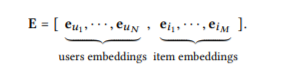

#### Embedding propagation

The embedding table is propagated through the network using the formula shown in the figure below.

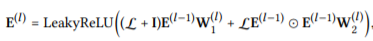

The components of the formula are as follows,

- **E⁽ˡ⁾**: the embedding table after l steps of embedding propagation, where E⁽⁰⁾ is the initial embedding table,
- **LeakyReLU**: the rectified linear unit used as activation function,
- **W**: the weights trained by the network,
- **I**: an identity matrix,
- **L**: the Laplacian matrix for the user-item graph, which is formulated as

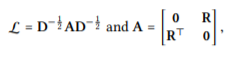

#### Architecture

![](https://github.com/recohut/reco-static/raw/master/media/images/120222_ncf.png)

In [ ]:
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, layers, reg, node_dropout, mess_dropout,
        adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.adj_mtx = adj_mtx
        self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])
        self.reg = reg
        self.layers = layers
        self.n_layers = len(self.layers)
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout

        #self.u_g_embeddings = nn.Parameter(torch.empty(n_users, emb_dim+np.sum(self.layers)))
        #self.i_g_embeddings = nn.Parameter(torch.empty(n_items, emb_dim+np.sum(self.layers)))

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

        # Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
        self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
        self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        weight_size_list = [self.emb_dim] + self.layers

        for k in range(self.n_layers):
            weight_dict['W_gc_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_gc_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
            
            weight_dict['W_bi_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_bi_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
           
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix
        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
        L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L

        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)

        all_embeddings = [ego_embeddings]

        # forward pass for 'n' propagation layers
        for k in range(self.n_layers):

            # weighted sum messages of neighbours
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

            # transformed sum weighted sum messages of neighbours
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbours
            bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
            # transformed bi messages of neighbours
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

            # non-linear activation 
            ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
            # + message dropout
            mess_dropout_mask = nn.Dropout(self.mess_dropout)
            ego_embeddings = mess_dropout_mask(ego_embeddings)

            # normalize activation
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings.append(norm_embeddings)

        all_embeddings = torch.cat(all_embeddings, 1)
        
        # back to user/item dimension
        u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

        self.u_g_embeddings = nn.Parameter(u_g_embeddings)
        self.i_g_embeddings = nn.Parameter(i_g_embeddings)
        
        u_emb = u_g_embeddings[u] # user embeddings
        p_emb = i_g_embeddings[i] # positive item embeddings
        n_emb = i_g_embeddings[j] # negative item embeddings

        y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
        y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
        log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

        # compute bpr-loss
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg  = self.reg*l2norm
            bpr_loss =  -log_prob + l2reg

        return bpr_loss

### Training and Evaluation

Training is done using the standard PyTorch method. If you are already familiar with PyTorch, the following code should look familiar.

One of the most useful functions of PyTorch is the torch.nn.Sequential() function, that takes existing and custom torch.nn modules. This makes it very easy to build and train complete networks. However, due to the nature of NCGF model structure, usage of torch.nn.Sequential() is not possible and the forward pass of the network has to be implemented ‘manually’. Using the Bayesian personalized ranking (BPR) pairwise loss, the forward pass is implemented as follows:

n_users=943, n_items=1682
n_interactions=100000
n_train=80000, n_test=20000, sparsity=0.06305
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 1.4850668907165527 sec
Loaded adjacency-matrix (shape: (2625, 2625) ) in 0.018111467361450195 sec.
Initializing weights...
Weights initialized.
Start at 2021-07-12 09:57:58.311285
Using cuda for computations
Params on CUDA: True
Epoch: 0, Training time: 9.11s, Loss: 107.9355
Epoch: 1, Training time: 8.88s, Loss: 101.6095
Epoch: 2, Training time: 8.75s, Loss: 80.7764
Epoch: 3, Training time: 8.76s, Loss: 76.1915
Epoch: 4, Training time: 8.58s, Loss: 73.0698
Evaluate current model:
 Epoch: 4, Validation time: 1.51s 
 Loss: 73.0698: 
 Recall@20: 0.0623 
 NDCG@20: 0.2352
Epoch: 5, Training time: 8.84s, Loss: 69.3378
Epoch: 6, Training time: 8.71s, Loss: 64.4498
Epoch: 7, Training time: 8.67s, Loss: 60.1440
Epoch: 8, Training time: 8.76s, Loss: 56.8538
Epoch: 9, Training time: 8.78s, Los

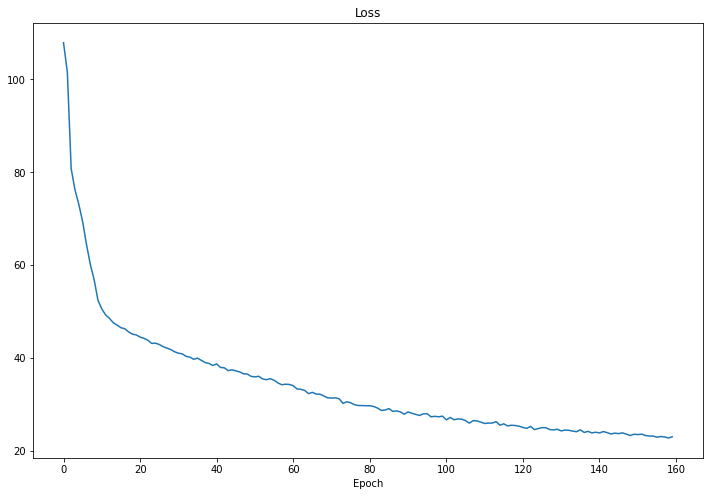

In [ ]:
# read parsed arguments
args = parse_args()
data_dir = args.data_dir
dataset = args.dataset
batch_size = args.batch_size
layers = eval(args.layers)
emb_dim = args.emb_dim
lr = args.lr
reg = args.reg
mess_dropout = args.mess_dropout
node_dropout = args.node_dropout
k = args.k

# generate the NGCF-adjacency matrix
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

# create model name and save
modelname =  "NGCF" + \
    "_bs_" + str(batch_size) + \
    "_nemb_" + str(emb_dim) + \
    "_layers_" + str(layers) + \
    "_nodedr_" + str(node_dropout) + \
    "_messdr_" + str(mess_dropout) + \
    "_reg_" + str(reg) + \
    "_lr_"  + str(lr)

# create NGCF model
model = NGCF(data_generator.n_users, 
              data_generator.n_items,
              emb_dim,
              layers,
              reg,
              node_dropout,
              mess_dropout,
              adj_mtx)
if use_cuda:
    model = model.cuda()

# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

print("Start at " + str(today))
print("Using " + str(device) + " for computations")
print("Params on CUDA: " + str(next(model.parameters()).is_cuda))

results = {"Epoch": [],
            "Loss": [],
            "Recall": [],
            "NDCG": [],
            "Training Time": []}

for epoch in range(args.n_epochs):

    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
        format(epoch, training_time, loss))

    # print test evaluation metrics every N epochs (provided by args.eval_N)
    if epoch % args.eval_N  == (args.eval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach(),
                                      model.i_g_embeddings.detach(),
                                      data_generator.R_train,
                                      data_generator.R_test,
                                      k)
        print(
            "Evaluate current model:\n",
            "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            "Loss: {:.4f}:".format(loss), "\n",
            "Recall@{}: {:.4f}".format(k, recall), "\n",
            "NDCG@{}: {:.4f}".format(k, ndcg)
            )

        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)
    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)

    if should_stop == True: break

# save
if args.save_results:
    date = today.strftime("%d%m%Y_%H%M")

    # save model as .pt file
    if os.path.isdir("./models"):
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")
    else:
        os.mkdir("./models")
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir("./results"):
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    else:
        os.mkdir("./results")
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')

### Appendix

#### References
1. [https://medium.com/@yusufnoor_88274/implementing-neural-graph-collaborative-filtering-in-pytorch-4d021dff25f3](https://medium.com/@yusufnoor_88274/implementing-neural-graph-collaborative-filtering-in-pytorch-4d021dff25f3)
2. [https://github.com/xiangwang1223/neural_graph_collaborative_filtering](https://github.com/xiangwang1223/neural_graph_collaborative_filtering)
3. [https://arxiv.org/pdf/1905.08108.pdf](https://arxiv.org/pdf/1905.08108.pdf)
4. [https://github.com/metahexane/ngcf_pytorch_g61](https://github.com/metahexane/ngcf_pytorch_g61)

#### Next

Try out this notebook on the following datasets:

![](https://github.com/recohut/reco-static/raw/master/media/images/120222_data.png)

Compare out the performance with these baselines:

1. MF: This is matrix factorization optimized by the Bayesian
personalized ranking (BPR) loss, which exploits the user-item
direct interactions only as the target value of interaction function.
2. NeuMF: The method is a state-of-the-art neural CF model
which uses multiple hidden layers above the element-wise and
concatenation of user and item embeddings to capture their nonlinear feature interactions. Especially, we employ two-layered
plain architecture, where the dimension of each hidden layer
keeps the same.
3. CMN: It is a state-of-the-art memory-based model, where
the user representation attentively combines the memory slots
of neighboring users via the memory layers. Note that the firstorder connections are used to find similar users who interacted
with the same items.
4. HOP-Rec: This is a state-of-the-art graph-based model,
where the high-order neighbors derived from random walks
are exploited to enrich the user-item interaction data.
5. PinSage: PinSage is designed to employ GraphSAGE
on item-item graph. In this work, we apply it on user-item interaction graph. Especially, we employ two graph convolution
layers, and the hidden dimension is set equal
to the embedding size.
6. GC-MC: This model adopts GCN encoder to generate
the representations for users and items, where only the first-order
neighbors are considered. Hence one graph convolution layer,
where the hidden dimension is set as the embedding size, is used.

## A simple recommender with tensorflow
> A tutorial on how to build a simple deep learning based movie recommender using tensorflow library.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

tf.random.set_seed(343)

In [ ]:
# Clean up the logdir if it exists
import shutil
shutil.rmtree('logs', ignore_errors=True)

# Load TensorBoard extension for notebooks
%load_ext tensorboard

In [ ]:
movielens_ratings_file = 'https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_100K_ratings.csv?raw=true'
df_raw = pd.read_csv(movielens_ratings_file)
df_raw.head()

,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
df = df_raw.copy()
df.columns = ['userId', 'movieId', 'rating', 'timestamp']
user_ids = df['userId'].unique()
user_encoding = {x: i for i, x in enumerate(user_ids)}   # {user_id: index}
movie_ids = df['movieId'].unique()
movie_encoding = {x: i for i, x in enumerate(movie_ids)} # {movie_id: index}

df['user'] = df['userId'].map(user_encoding)    # Map from IDs to indices
df['movie'] = df['movieId'].map(movie_encoding)

n_users = len(user_ids)
n_movies = len(movie_ids)

min_rating = min(df['rating'])
max_rating = max(df['rating'])

print(f'Number of users: {n_users}\nNumber of movies: {n_movies}\nMin rating: {min_rating}\nMax rating: {max_rating}')

# Shuffle the data
df = df.sample(frac=1, random_state=42)

Number of users: 943
Number of movies: 1682
Min rating: 1.0
Max rating: 5.0


### Scheme of the model

![](https://github.com/recohut/reco-static/raw/master/media/images/120222_scheme.png)

In [ ]:
class MatrixFactorization(models.Model):
    def __init__(self, n_users, n_movies, n_factors, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.n_users = n_users
        self.n_movies = n_movies
        self.n_factors = n_factors
        
        # We specify the size of the matrix,
        # the initializer (truncated normal distribution)
        # and the regularization type and strength (L2 with lambda = 1e-6)
        self.user_emb = layers.Embedding(n_users, 
                                         n_factors, 
                                         embeddings_initializer='he_normal',
                                         embeddings_regularizer=keras.regularizers.l2(1e-6),
                                         name='user_embedding')
        self.movie_emb = layers.Embedding(n_movies, 
                                          n_factors, 
                                          embeddings_initializer='he_normal',
                                          embeddings_regularizer=keras.regularizers.l2(1e-6),
                                          name='movie_embedding')
        
        # Embedding returns a 3D tensor with one dimension = 1, so we reshape it to a 2D tensor
        self.reshape = layers.Reshape((self.n_factors,))
        
        # Dot product of the latent vectors
        self.dot = layers.Dot(axes=1)

    def call(self, inputs):
        # Two inputs
        user, movie = inputs
        u = self.user_emb(user)
        u = self.reshape(u)
    
        m = self.movie_emb(movie)
        m = self.reshape(m)
        
        return self.dot([u, m])

n_factors = 50
model = MatrixFactorization(n_users, n_movies, n_factors)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError()
)

In [ ]:
try:
    model.summary()
except ValueError as e:
    print(e, type(e))

This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build. <class 'ValueError'>


This is why building models via subclassing is a bit annoying - you can run into errors such as this. We'll fix it by calling the model with some fake data so it knows the shapes of the inputs.

In [ ]:
_ = model([np.array([1, 2, 3]), np.array([2, 88, 5])])
model.summary()

Model: "matrix_factorization_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embedding (Embedding)   multiple                  47150     
_________________________________________________________________
movie_embedding (Embedding)  multiple                  84100     
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
dot_1 (Dot)                  multiple                  0         
Total params: 131,250
Trainable params: 131,250
Non-trainable params: 0
_________________________________________________________________


We're going to expand our toolbox by introducing callbacks. Callbacks can be used to monitor our training progress, decay the learning rate, periodically save the weights or even stop early in case of detected overfitting. In Keras, they are really easy to use: you just create a list of desired callbacks and pass it to the model.fit method. It's also really easy to define your own by subclassing the Callback class. You can also specify when they will be triggered - the default is at the end of every epoch.

We'll use two: an early stopping callback which will monitor our loss and stop the training early if needed and TensorBoard, a utility for visualizing models, monitoring the training progress and much more.

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir='logs')
]

history = model.fit(
    x=(df['user'].values, df['movie'].values),  # The model has two inputs!
    y=df['rating'],
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/20
704/704 [==============================] - 3s 3ms/step - loss: 12.0905 - val_loss: 5.5121
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 2.1751 - val_loss: 1.2149
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 1.0271 - val_loss: 0.9839
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.9003 - val_loss: 0.9266
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.8470 - val_loss: 0.8996
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.8046 - val_loss: 0.8786
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.7667 - val_loss: 0.8680
Epoch 8/20
704/704 [==============================] - 2s 3ms/step - loss: 0.7329 - val_loss: 0.8618
Epoch 9/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6999 - val_loss: 0.8558
Epoch 10/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6688 - val_loss: 0.855

We see that we stopped early because the validation loss was not improving. Now, we'll open TensorBoard (it's a separate program called via command-line) to read the written logs and visualize the loss over all epochs. We will also look at how to visualize the model as a computational graph.

In [ ]:
# Run TensorBoard and specify the log dir
%tensorboard --logdir logs

We've seen how easy it is to implement a recommender system with Keras and use a few utilities to make it easier to experiment. Note that this model is still quite basic and we could easily improve it: we could try adding a bias for each user and movie or adding non-linearity by using a sigmoid function and then rescaling the output. It could also be extended to use other features of a user or movie.

Next, we'll try a bigger, more state-of-the-art model: a deep autoencoder.

We'll apply a more advanced algorithm to the same dataset as before, taking a different approach. We'll use a deep autoencoder network, which attempts to reconstruct its input and with that gives us ratings for unseen user / movie pairs.

![](https://github.com/recohut/reco-static/raw/master/media/images/120222_algo.png)

Preprocessing will be a bit different due to the difference in our model. Our autoencoder will take a vector of all ratings for a movie and attempt to reconstruct it. However, our input vector will have a lot of zeroes due to the sparsity of our data. We'll modify our loss so our model won't predict zeroes for those combinations - it will actually predict unseen ratings.

To facilitate this, we'll use the sparse tensor that TF supports. Note: to make training easier, we'll transform it to dense form, which would not work in larger datasets - we would have to preprocess the data in a different way or stream it into the model.

### Sparse representation and autoencoder reconstruction

![](https://github.com/recohut/reco-static/raw/master/media/images/120222_ae.png)

In [ ]:
df_raw.head()

,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
# Create a sparse tensor: at each user, movie location, we have a value, the rest is 0
sparse_x = tf.sparse.SparseTensor(indices=df[['movie', 'user']].values, values=df['rating'], dense_shape=(n_movies, n_users))

# Transform it to dense form and to float32 (good enough precision)
dense_x = tf.cast(tf.sparse.to_dense(tf.sparse.reorder(sparse_x)), tf.float32)

# Shuffle the data
x = tf.random.shuffle(dense_x, seed=42)

Now, let's create the model. We'll have to specify the input shape. Because we have 9724 movies and only 610 users, we'll prefer to predict ratings for movies instead of users - this way, our dataset is larger.

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense1 = layers.Dense(28, activation='selu', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dropout = layers.Dropout(0.3)
        
    def call(self, x):
        d1 = self.dense1(x)
        d2 = self.dense2(d1)
        d3 = self.dense3(d2)
        return self.dropout(d3)
        
        
class Decoder(layers.Layer):
    def __init__(self, n, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense1 = layers.Dense(56, activation='selu', kernel_initializer='glorot_uniform')
        self.dense2 = layers.Dense(28, activation='selu', kernel_initializer='glorot_uniform')
        self.dense3 = layers.Dense(n, activation='selu', kernel_initializer='glorot_uniform')

    def call(self, x):
        d1 = self.dense1(x)
        d2 = self.dense2(d1)
        return self.dense3(d2)

n = n_users
inputs = layers.Input(shape=(n,))

encoder = Encoder()
decoder = Decoder(n)

enc1 = encoder(inputs)
dec1 = decoder(enc1)
enc2 = encoder(dec1)
dec2 = decoder(enc2)

model = models.Model(inputs=inputs, outputs=dec2, name='DeepAutoencoder')
model.summary()

Model: "DeepAutoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 943)]        0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (None, 56)           31248       input_1[0][0]                    
                                                                 decoder[0][0]                    
__________________________________________________________________________________________________
decoder (Decoder)               (None, 943)          32135       encoder[0][0]                    
                                                                 encoder[1][0]                    
Total params: 63,383
Trainable params: 63,383
Non-trainable params: 0
______________

Because our inputs are sparse, we'll need to create a modified mean squared error function. We have to look at which ratings are zero in the ground truth and remove them from our loss calculation (if we didn't, our model would quickly learn to predict zeros almost everywhere). We'll use masking - first get a boolean mask of non-zero values and then extract them from the result.

In [ ]:
def masked_mse(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)
    se = tf.boolean_mask(tf.square(y_true - y_pred), mask)
    return tf.reduce_mean(se)

model.compile(
    loss=masked_mse,
    optimizer=keras.optimizers.Adam()
)

The model training will be similar as before - we'll use early stopping and TensorBoard. Our batch size will be smaller due to the lower number of examples. Note that we are passing the same array for both x and y, because the autoencoder reconstructs its input.

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=5,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir='logs')
]

model.fit(
    x, 
    x, 
    batch_size=16, 
    epochs=100, 
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/100
95/95 [==============================] - 2s 7ms/step - loss: 4.6136 - val_loss: 1.1074
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 1.1491 - val_loss: 1.0088
Epoch 3/100
95/95 [==============================] - 0s 5ms/step - loss: 1.0577 - val_loss: 0.9768
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 1.0257 - val_loss: 0.9758
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.9971 - val_loss: 0.9774
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 0.9812 - val_loss: 0.9604
Epoch 7/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9598 - val_loss: 0.9275
Epoch 8/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9501 - val_loss: 0.9253
Epoch 9/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9177 - val_loss: 0.9159
Epoch 10/100
95/95 [==============================] - 0s 5ms/step - loss: 0.9193 - val_loss: 0.9189
Epoch 11/

Let's visualize our loss and the model itself with TensorBoard.

In [ ]:
%tensorboard --logdir logs

That's it! We've seen how to use TensorFlow to implement recommender systems in a few different ways. I hope this short introduction has been informative and has prepared you to use TF on new problems. Thank you for your attention!